# Exploratory Data Analysis

**Author: Adryan R A**

This notebook contains exploratory data analysis (EDA) for the AI Workflow Capstone project, focusing on understanding the revenue data patterns and characteristics that will inform our time series forecasting approach.

## 1. Import Required Libraries

First, we'll import all the necessary libraries for data analysis, visualization, and connecting to our database.

In [1]:
# Import required libraries for comprehensive EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import sqlite3
import warnings
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Configure visualization settings
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set pandas display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("All libraries imported successfully")

All libraries imported successfully


## 2. Load and Inspect Data

Let's load the invoice data from our database and get a first look at the dataset structure.

In [2]:
# Function to load data from database or JSON files
def load_invoice_data():
    """Load invoice data from database or fallback to JSON files"""
    
    # First, try to load from the database if it exists
    try:
        from data_ingestion import DataIngestionEngine
        
        # Initialize the data ingestion engine
        engine = DataIngestionEngine(database_url="sqlite:///file.db", data_directory="cs-train")
        
        # Try to load from database
        df = engine.export_to_dataframe()
        
        if len(df) > 0:
            print(f"Loaded {len(df):,} records from database")
            return df
        else:
            print("Database is empty, loading from JSON files...")
            
    except Exception as e:
        print(f"Could not load from database: {e}")
        print("Loading data from JSON files instead...")
    
    # Fallback: Load directly from JSON files
    import json
    import glob
    
    all_data = []
    json_files = glob.glob("cs-train/*.json")
    
    if not json_files:
        print("No JSON files found in cs-train directory")
        return pd.DataFrame()
    
    for file_path in json_files:
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
                
            # Normalize field names
            for record in data:
                # Handle field name variations
                if 'StreamID' in record:
                    record['stream_id'] = record.pop('StreamID')
                if 'TimesViewed' in record:
                    record['times_viewed'] = record.pop('TimesViewed')
                
                # Add source file for tracking
                record['source_file'] = os.path.basename(file_path)
                
                # Create date field
                if 'year' in record and 'month' in record and 'day' in record:
                    try:
                        record['date'] = pd.to_datetime(f"{record['year']}-{record['month']}-{record['day']}")
                    except:
                        record['date'] = None
            
            all_data.extend(data)
            print(f"Loaded {len(data):,} records from {file_path}")
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    if all_data:
        df = pd.DataFrame(all_data)
        print(f"Total loaded: {len(df):,} records from {len(json_files)} files")
        return df
    else:
        print("No data could be loaded")
        return pd.DataFrame()

# Load the data
df = load_invoice_data()

2025-07-25 20:58:56,703 - INFO - Database tables created/verified successfully


Loaded 36,128 records from database


In [5]:
# Basic dataset inspection
if len(df) > 0:
    print("="*60)
    print("DATASET OVERVIEW")
    print("="*60)
    
    print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"Data Period: {df['date'].min()} to {df['date'].max()}" if 'date' in df.columns else "")
    print(f"Countries: {df['country'].nunique()}" if 'country' in df.columns else "")
    print(f"Unique Customers: {df['customer_id'].nunique()}" if 'customer_id' in df.columns else "")
    print(f"Unique Streams: {df['stream_id'].nunique()}" if 'stream_id' in df.columns else "")
    
    print("\n" + "="*60)
    print("COLUMN INFORMATION")
    print("="*60)
    print(df.info())
    
    print("\n" + "="*60)
    print("FIRST 5 ROWS")
    print("="*60)
    display(df.head())
    
    print("\n" + "="*60)
    print("DATA TYPES AND NULL VALUES")
    print("="*60)
    data_overview = pd.DataFrame({
        'Data Type': df.dtypes,
        'Non-Null Count': df.count(),
        'Null Count': df.isnull().sum(),
        'Null Percentage': (df.isnull().sum() / len(df) * 100).round(2)
    })
    display(data_overview)
    
else:
    print("No data available for analysis")

DATASET OVERVIEW
Dataset Shape: 36,128 rows × 13 columns
Data Period: 2017-11-30 to 2019-07-31
Countries: 20
Unique Customers: 836
Unique Streams: 3552

COLUMN INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36128 entries, 0 to 36127
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            36128 non-null  int64         
 1   invoice       36128 non-null  object        
 2   country       36128 non-null  object        
 3   customer_id   17021 non-null  float64       
 4   stream_id     36128 non-null  object        
 5   price         36128 non-null  float64       
 6   times_viewed  36128 non-null  int64         
 7   year          36128 non-null  int64         
 8   month         36128 non-null  int64         
 9   day           36128 non-null  int64         
 10  date          36128 non-null  object        
 11  created_at    36128 non-null  datetime64[ns]
 12  source_file   

,id,invoice,country,customer_id,stream_id,price,times_viewed,year,month,day,date,created_at,source_file
0,1,536876,United Kingdom,NaN,22580,11.87,3,2018,11,30,2018-11-30,2025-07-25 13:16:15.295834,invoices-2018-11.json
1,2,536876,United Kingdom,NaN,22588,5.06,6,2018,11,30,2018-11-30,2025-07-25 13:16:15.295840,invoices-2018-11.json
2,3,536876,United Kingdom,NaN,22963,1.66,5,2018,11,30,2018-11-30,2025-07-25 13:16:15.295842,invoices-2018-11.json
3,4,536876,United Kingdom,NaN,22962,1.66,4,2018,11,30,2018-11-30,2025-07-25 13:16:15.295844,invoices-2018-11.json
4,5,536876,United Kingdom,NaN,22961,3.36,6,2018,11,30,2018-11-30,2025-07-25 13:16:15.295845,invoices-2018-11.json



DATA TYPES AND NULL VALUES


,Data Type,Non-Null Count,Null Count,Null Percentage
id,int64,36128,0,0.00
invoice,object,36128,0,0.00
country,object,36128,0,0.00
customer_id,float64,17021,19107,52.89
stream_id,object,36128,0,0.00
price,float64,36128,0,0.00
times_viewed,int64,36128,0,0.00
year,int64,36128,0,0.00
month,int64,36128,0,0.00
day,int64,36128,0,0.00


## 3. Data Quality Assessment

Let's assess the quality of our data by examining missing values, duplicates, and potential data issues.

DATA QUALITY ASSESSMENT
MISSING VALUES ANALYSIS:


,Missing Count,Missing Percentage
customer_id,19107,52.89



DUPLICATE RECORDS: 0 (0.00%)

NUMERICAL DATA RANGES:
  price: 0.00 to 38970.00
    Zero values: 285 (0.8%)
    Negative values: 0
  times_viewed: 0.00 to 24.00
    Zero values: 308 (0.9%)
    Negative values: 0

CATEGORICAL DATA SUMMARY:
  country: 20 unique values
    Values: ['United Kingdom', 'European Community', 'Germany', 'Netherlands', 'France', 'EIRE', 'Portugal', 'Switzerland', 'Italy', 'Sweden', 'Spain', 'Norway', 'Bahrain', 'Greece', 'Belgium', 'Australia', 'Austria', 'Cyprus', 'Finland', 'Israel']
  invoice: 1,701 unique values


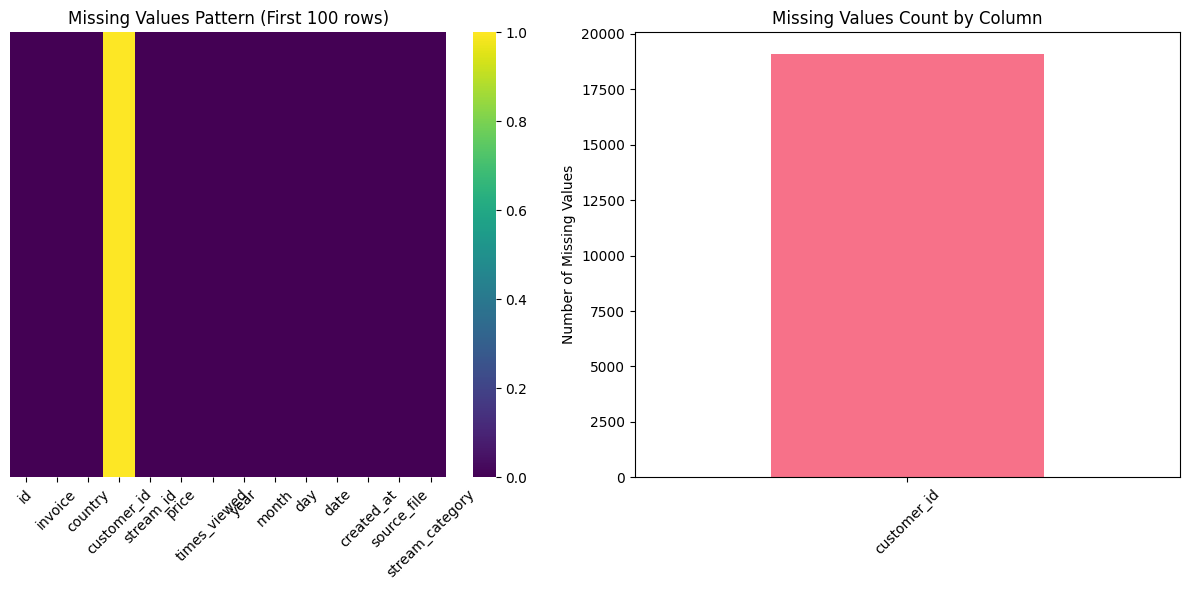

In [9]:
# Data Quality Assessment
if len(df) > 0:
    print("="*60)
    print("DATA QUALITY ASSESSMENT")
    print("="*60)
    
    # Missing values analysis
    missing_data = df.isnull().sum()
    missing_percentage = (missing_data / len(df)) * 100
    
    print("MISSING VALUES ANALYSIS:")
    missing_summary = pd.DataFrame({
        'Missing Count': missing_data,
        'Missing Percentage': missing_percentage.round(2)
    }).sort_values('Missing Count', ascending=False)
    
    display(missing_summary[missing_summary['Missing Count'] > 0])
    
    # Duplicate analysis
    duplicate_count = df.duplicated().sum()
    print(f"\nDUPLICATE RECORDS: {duplicate_count:,} ({(duplicate_count/len(df)*100):.2f}%)")
    
    # Data range checks
    print("\nNUMERICAL DATA RANGES:")
    numerical_cols = ['price', 'times_viewed']
    if all(col in df.columns for col in numerical_cols):
        for col in numerical_cols:
            print(f"  {col}: {df[col].min():.2f} to {df[col].max():.2f}")
            print(f"    Zero values: {(df[col] == 0).sum():,} ({(df[col] == 0).sum()/len(df)*100:.1f}%)")
            print(f"    Negative values: {(df[col] < 0).sum():,}")
    
    # Unique value counts for categorical data
    print("\nCATEGORICAL DATA SUMMARY:")
    categorical_cols = ['country', 'invoice']
    for col in categorical_cols:
        if col in df.columns:
            unique_count = df[col].nunique()
            print(f"  {col}: {unique_count:,} unique values")
            if unique_count <= 20:
                print(f"    Values: {list(df[col].unique())}")
    
    # Create missing values heatmap
    if missing_data.sum() > 0:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        missing_matrix = df.isnull()
        sns.heatmap(missing_matrix.head(100), 
                   cbar=True, yticklabels=False, cmap='viridis')
        plt.title('Missing Values Pattern (First 100 rows)')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 2, 2)
        missing_counts = df.isnull().sum()
        missing_counts = missing_counts[missing_counts > 0]
        if len(missing_counts) > 0:
            missing_counts.plot(kind='bar')
            plt.title('Missing Values Count by Column')
            plt.ylabel('Number of Missing Values')
            plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        
else:
    print("No data available for quality assessment")

## 4. Exploratory Data Analysis - Basic Statistics

Let's examine the basic statistical properties of our numerical variables and identify patterns in the data.

DESCRIPTIVE STATISTICS


,price,times_viewed
count,36128.000000,36128.000000
mean,7.459571,4.667294
std,255.161718,4.951423
min,0.000000,0.000000
25%,1.450000,1.000000
50%,2.510000,2.000000
75%,4.950000,6.000000
max,38970.000000,24.000000



ADDITIONAL STATISTICS:

PRICE:
  Median: 2.51
  Mode: 1.25
  Skewness: 118.97
  Kurtosis: 16294.46

TIMES_VIEWED:
  Median: 2.00
  Mode: 1.00
  Skewness: 1.62
  Kurtosis: 2.24


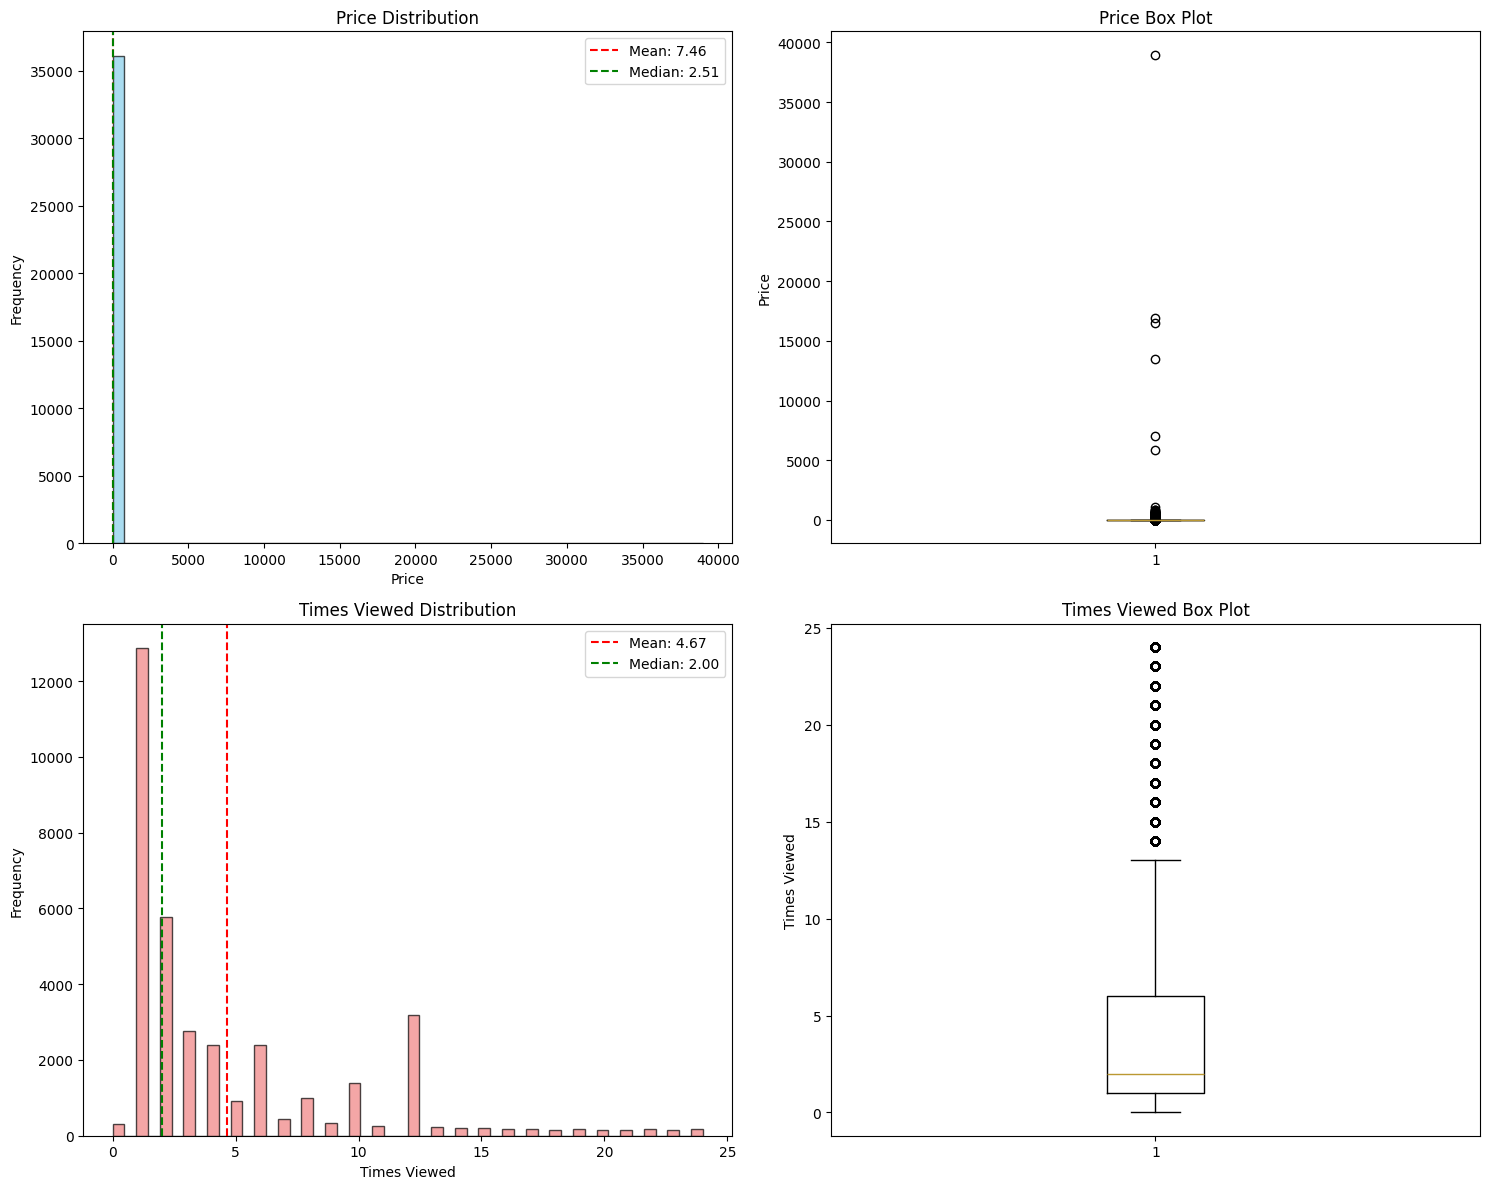


OUTLIER ANALYSIS (using IQR method):
  price: 2,520 outliers (7.0%)
    Range: [-3.80, 10.20]
    Min outlier: 10.39
    Max outlier: 38970.00
  times_viewed: 1,889 outliers (5.2%)
    Range: [-6.50, 13.50]
    Min outlier: 14.00
    Max outlier: 24.00


In [4]:
# Basic Statistical Analysis
if len(df) > 0:
    print("="*60)
    print("DESCRIPTIVE STATISTICS")
    print("="*60)
    
    # Descriptive statistics for numerical columns
    numerical_cols = ['price', 'times_viewed']
    if all(col in df.columns for col in numerical_cols):
        desc_stats = df[numerical_cols].describe()
        display(desc_stats)
        
        # Additional statistics
        print("\nADDITIONAL STATISTICS:")
        for col in numerical_cols:
            print(f"\n{col.upper()}:")
            print(f"  Median: {df[col].median():.2f}")
            print(f"  Mode: {df[col].mode().iloc[0]:.2f}" if len(df[col].mode()) > 0 else "  Mode: N/A")
            print(f"  Skewness: {df[col].skew():.2f}")
            print(f"  Kurtosis: {df[col].kurtosis():.2f}")
    
    # Create distribution plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    if 'price' in df.columns:
        # Price distribution
        axes[0, 0].hist(df['price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, 0].set_title('Price Distribution')
        axes[0, 0].set_xlabel('Price')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].axvline(df['price'].mean(), color='red', linestyle='--', label=f'Mean: {df["price"].mean():.2f}')
        axes[0, 0].axvline(df['price'].median(), color='green', linestyle='--', label=f'Median: {df["price"].median():.2f}')
        axes[0, 0].legend()
        
        # Price box plot
        axes[0, 1].boxplot(df['price'])
        axes[0, 1].set_title('Price Box Plot')
        axes[0, 1].set_ylabel('Price')
    
    if 'times_viewed' in df.columns:
        # Times viewed distribution
        axes[1, 0].hist(df['times_viewed'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[1, 0].set_title('Times Viewed Distribution')
        axes[1, 0].set_xlabel('Times Viewed')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].axvline(df['times_viewed'].mean(), color='red', linestyle='--', label=f'Mean: {df["times_viewed"].mean():.2f}')
        axes[1, 0].axvline(df['times_viewed'].median(), color='green', linestyle='--', label=f'Median: {df["times_viewed"].median():.2f}')
        axes[1, 0].legend()
        
        # Times viewed box plot
        axes[1, 1].boxplot(df['times_viewed'])
        axes[1, 1].set_title('Times Viewed Box Plot')
        axes[1, 1].set_ylabel('Times Viewed')
    
    plt.tight_layout()
    plt.show()
    
    # Outlier analysis
    print("\nOUTLIER ANALYSIS (using IQR method):")
    for col in numerical_cols:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            print(f"  {col}: {len(outliers):,} outliers ({len(outliers)/len(df)*100:.1f}%)")
            print(f"    Range: [{lower_bound:.2f}, {upper_bound:.2f}]")
            
            if len(outliers) > 0:
                print(f"    Min outlier: {outliers[col].min():.2f}")
                print(f"    Max outlier: {outliers[col].max():.2f}")

else:
    print("No data available for statistical analysis")

## 5. Revenue Analysis by Geographic Segments

Now let's analyze revenue patterns across different countries and geographic regions to identify top-performing markets.

GEOGRAPHIC REVENUE ANALYSIS
REVENUE BY COUNTRY (Top 15):


,Total_Revenue,Transaction_Count,Avg_Transaction_Value,Unique_Customers,Total_Engagement
country,,,,,
United Kingdom,259244.78,33626,7.71,750,147603
Spain,2183.39,269,8.12,8,1473
EIRE,2120.62,533,3.98,3,4254
Germany,1677.43,451,3.72,22,3698
France,1314.38,342,3.84,17,2969
Greece,591.64,175,3.38,1,1303
Netherlands,587.65,210,2.80,4,2387
Switzerland,288.46,79,3.65,2,850
Norway,273.59,93,2.94,2,972



MARKET SHARE ANALYSIS:
   1. United Kingdom      : $259,244.78 ( 96.2%)
   2. Spain               : $  2,183.39 (  0.8%)
   3. EIRE                : $  2,120.62 (  0.8%)
   4. Germany             : $  1,677.43 (  0.6%)
   5. France              : $  1,314.38 (  0.5%)
   6. Greece              : $    591.64 (  0.2%)
   7. Netherlands         : $    587.65 (  0.2%)
   8. Switzerland         : $    288.46 (  0.1%)
   9. Norway              : $    273.59 (  0.1%)
  10. Italy               : $    256.95 (  0.1%)

CONCENTRATION METRICS:
  Total Countries: 20
  Top 5 Countries Revenue Share: 98.9%
  Geographic Diversity Index: 0.011


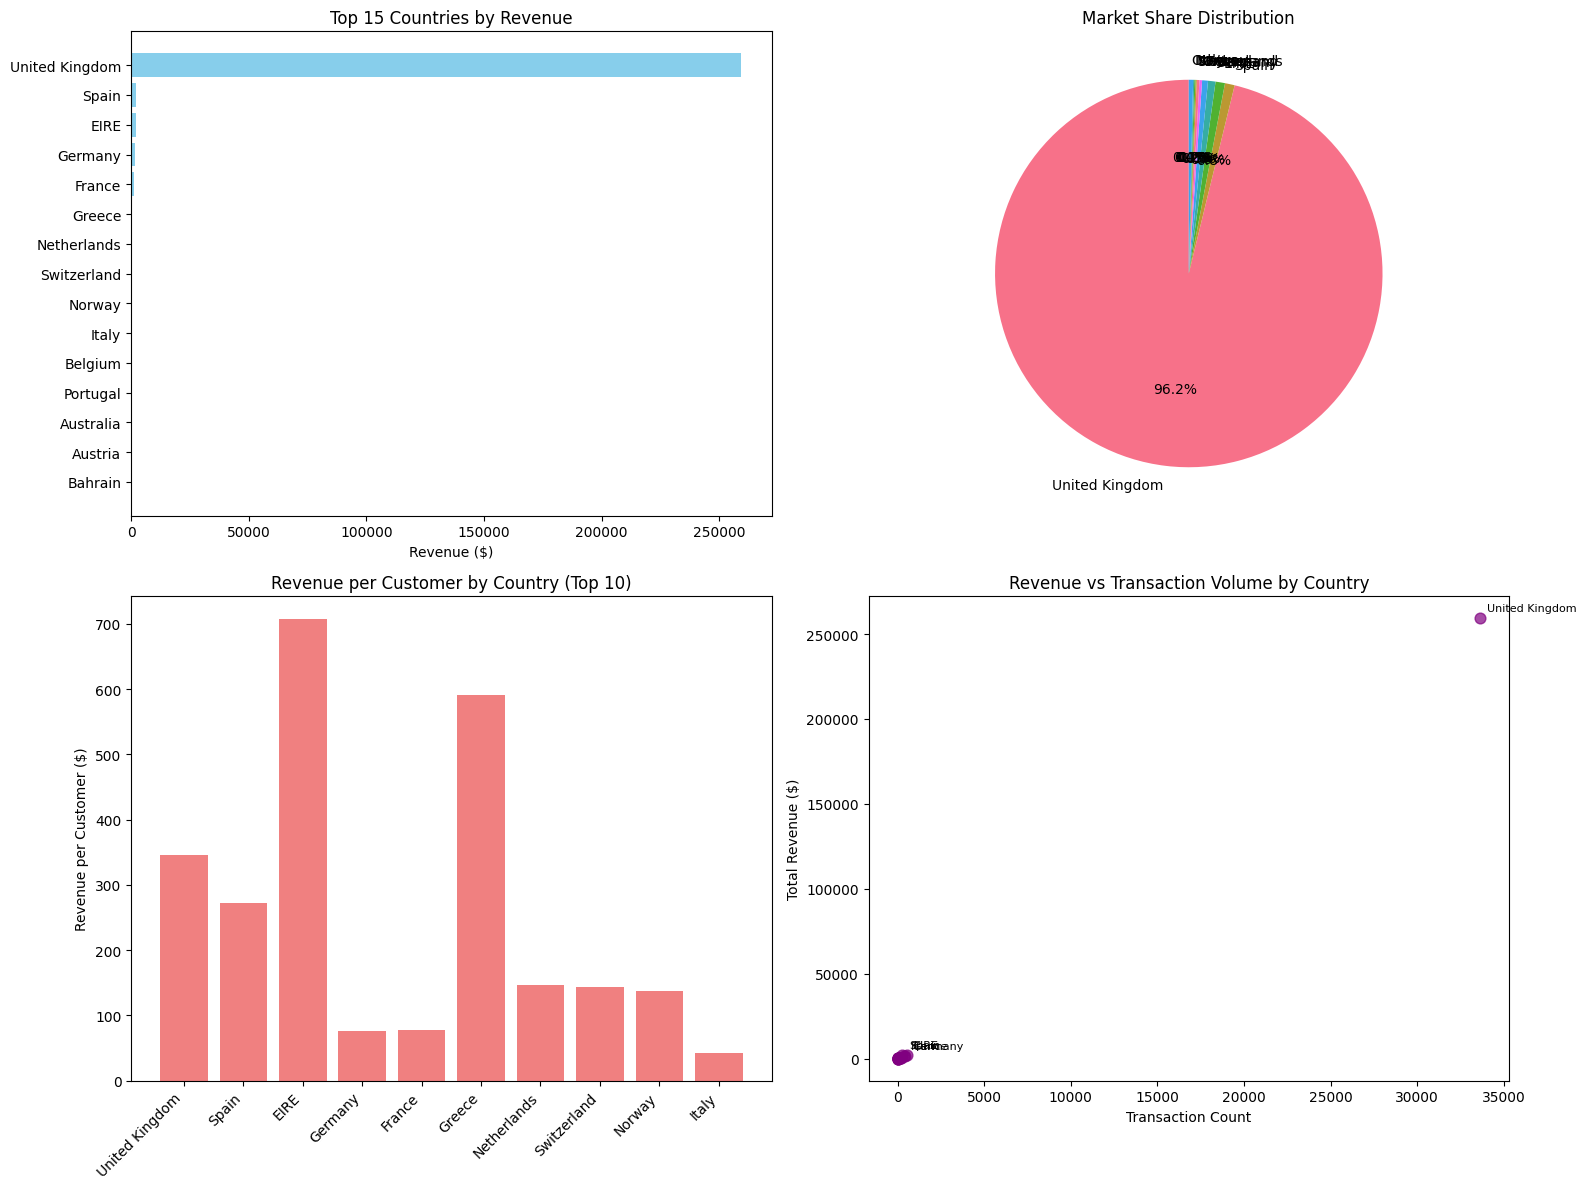


INTERACTIVE GEOGRAPHIC VISUALIZATION:
Interactive visualization unavailable: name 'go' is not defined...
Static visualizations displayed successfully above

GEOGRAPHIC INSIGHTS:
High-value markets (top 25% revenue per customer): 5 countries
Best revenue per customer: 345.66 (United Kingdom)
  Volume growth opportunities: 3 countries with high transaction volume but low revenue per customer
Revenue distribution stability: Volatile (CV: 4.29)


In [5]:
# Geographic Analysis
if len(df) > 0:
    print("="*60)
    print("GEOGRAPHIC REVENUE ANALYSIS")
    print("="*60)
    
    if 'country' in df.columns:
        # Country-wise revenue analysis
        country_revenue = df.groupby('country').agg({
            'price': ['sum', 'count', 'mean'],
            'customer_id': 'nunique' if 'customer_id' in df.columns else 'count',
            'times_viewed': 'sum' if 'times_viewed' in df.columns else 'count'
        }).round(2)
        
        country_revenue.columns = ['Total_Revenue', 'Transaction_Count', 'Avg_Transaction_Value', 'Unique_Customers', 'Total_Engagement']
        country_revenue = country_revenue.sort_values('Total_Revenue', ascending=False)
        
        print(f"REVENUE BY COUNTRY (Top 15):")
        display(country_revenue.head(15))
        
        # Market share calculation
        total_revenue = country_revenue['Total_Revenue'].sum()
        country_revenue['Market_Share_%'] = (country_revenue['Total_Revenue'] / total_revenue * 100).round(2)
        country_revenue['Revenue_per_Customer'] = (country_revenue['Total_Revenue'] / country_revenue['Unique_Customers']).round(2)
        
        print(f"\nMARKET SHARE ANALYSIS:")
        top_countries = country_revenue.head(10)
        for i, (country, data) in enumerate(top_countries.iterrows(), 1):
            print(f"  {i:2d}. {country:20s}: ${data['Total_Revenue']:>10,.2f} ({data['Market_Share_%']:>5.1f}%)")
        
        # Revenue concentration analysis
        top_5_revenue = country_revenue.head(5)['Total_Revenue'].sum()
        concentration_ratio = (top_5_revenue / total_revenue) * 100
        
        print(f"\nCONCENTRATION METRICS:")
        print(f"  Total Countries: {len(country_revenue)}")
        print(f"  Top 5 Countries Revenue Share: {concentration_ratio:.1f}%")
        print(f"  Geographic Diversity Index: {(1 - concentration_ratio/100):.3f}")
        
        # Create visualizations
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Top 15 countries revenue bar chart
        top_15 = country_revenue.head(15)
        axes[0, 0].barh(range(len(top_15)), top_15['Total_Revenue'], color='skyblue')
        axes[0, 0].set_yticks(range(len(top_15)))
        axes[0, 0].set_yticklabels(top_15.index)
        axes[0, 0].set_xlabel('Revenue ($)')
        axes[0, 0].set_title('Top 15 Countries by Revenue')
        axes[0, 0].invert_yaxis()
        
        # Market share pie chart (Top 10)
        top_10_countries = country_revenue.head(10)
        others_revenue = country_revenue.iloc[10:]['Total_Revenue'].sum() if len(country_revenue) > 10 else 0
        
        pie_data = list(top_10_countries['Total_Revenue'])
        pie_labels = list(top_10_countries.index)
        
        if others_revenue > 0:
            pie_data.append(others_revenue)
            pie_labels.append('Others')
        
        axes[0, 1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
        axes[0, 1].set_title('Market Share Distribution')
        
        # Revenue per customer by country
        top_10_rev_per_customer = country_revenue.head(10)
        axes[1, 0].bar(range(len(top_10_rev_per_customer)), top_10_rev_per_customer['Revenue_per_Customer'], color='lightcoral')
        axes[1, 0].set_xticks(range(len(top_10_rev_per_customer)))
        axes[1, 0].set_xticklabels(top_10_rev_per_customer.index, rotation=45, ha='right')
        axes[1, 0].set_ylabel('Revenue per Customer ($)')
        axes[1, 0].set_title('Revenue per Customer by Country (Top 10)')
        
        # Transaction count vs Revenue scatter
        axes[1, 1].scatter(country_revenue['Transaction_Count'], country_revenue['Total_Revenue'], 
                          alpha=0.7, color='purple', s=60)
        axes[1, 1].set_xlabel('Transaction Count')
        axes[1, 1].set_ylabel('Total Revenue ($)')
        axes[1, 1].set_title('Revenue vs Transaction Volume by Country')
        
        # Add country labels for top 5
        for i, (country, data) in enumerate(country_revenue.head(5).iterrows()):
            axes[1, 1].annotate(country, (data['Transaction_Count'], data['Total_Revenue']), 
                               xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        plt.tight_layout()
        plt.show()
        
        # Try Plotly visualization as an alternative
        try:
            print(f"\nINTERACTIVE GEOGRAPHIC VISUALIZATION:")
            
            # Create Plotly bar chart
            fig_plotly = go.Figure()
            
            fig_plotly.add_trace(go.Bar(
                x=top_15['Total_Revenue'],
                y=top_15.index,
                orientation='h',
                marker_color='lightblue',
                text=[f'${val:,.0f}' for val in top_15['Total_Revenue']],
                textposition='auto',
            ))
            
            fig_plotly.update_layout(
                title='Top 15 Countries by Revenue (Interactive)',
                xaxis_title='Revenue ($)',
                yaxis_title='Country',
                height=600,
                yaxis={'categoryorder': 'total ascending'}
            )
            
            fig_plotly.show()
            
        except Exception as e:
            print(f"Interactive visualization unavailable: {str(e)[:100]}...")
            print("Static visualizations displayed successfully above")
        
        # Geographic insights
        print(f"\nGEOGRAPHIC INSIGHTS:")
        
        # High-value markets
        high_value_threshold = country_revenue['Revenue_per_Customer'].quantile(0.75)
        high_value_markets = country_revenue[country_revenue['Revenue_per_Customer'] >= high_value_threshold]
        
        print(f"High-value markets (top 25% revenue per customer): {len(high_value_markets)} countries")
        if len(high_value_markets) > 0:
            print(f"Best revenue per customer: {high_value_markets['Revenue_per_Customer'].iloc[0]:.2f} ({high_value_markets.index[0]})")
        
        # Market penetration opportunities
        high_volume_low_value = country_revenue[
            (country_revenue['Transaction_Count'] > country_revenue['Transaction_Count'].median()) &
            (country_revenue['Revenue_per_Customer'] < country_revenue['Revenue_per_Customer'].median())
        ]
        
        if len(high_volume_low_value) > 0:
            print(f"  Volume growth opportunities: {len(high_volume_low_value)} countries with high transaction volume but low revenue per customer")
        
        # Revenue stability analysis
        if len(country_revenue) >= 3:
            revenue_std = country_revenue['Total_Revenue'].std()
            revenue_mean = country_revenue['Total_Revenue'].mean()
            cv = revenue_std / revenue_mean if revenue_mean > 0 else 0
            
            print(f"Revenue distribution stability: {'Stable' if cv < 1 else 'Volatile'} (CV: {cv:.2f})")
    
    else:
        print("Country data not available for geographic analysis")

else:
    print("No data available for geographic analysis")

## 6. Customer Behavior Patterns

Let's analyze customer engagement patterns through viewing behavior, purchase frequency, and customer value segments.

CUSTOMER BEHAVIOR ANALYSIS
VIEWING BEHAVIOR ANALYSIS:
Total Views: 168,620
Average Views per Transaction: 4.67

Viewing Distribution:
    1 view: 13,178 (36.5%)
    2-5 views: 11,829 (32.7%)
    6-10 views: 5,552 (15.4%)
    11-20 views: 4,920 (13.6%)
    20+ views: 649 (1.8%)

CUSTOMER FREQUENCY ANALYSIS:
Customers with IDs: 17,021 transactions
Unique Customers: 836

Transaction Frequency per Customer:
Average: 20.36
Median: 14.00
Max: 298

TOP 10 CUSTOMERS BY VALUE:


,Total_Spent,Avg_Price,Transaction_Count,Total_Views
customer_id,,,,
15098.0,40278.90,8055.780000,5,20
14911.0,1222.87,4.103591,298,2286
12503.0,1126.00,1126.000000,1,3
17406.0,769.86,20.259474,38,336
12511.0,591.64,3.380800,175,1303
14606.0,556.26,3.160568,176,329
15311.0,496.37,2.519645,197,816
14088.0,490.91,6.914225,71,670
17841.0,466.67,2.430573,192,432



CUSTOMER SEGMENTATION:


Total_Spent                   Transaction_Count Total_Views
                   count       sum    mean              mean        mean
Segment                                                                 
Low Value            209   1375.35    6.58              3.45       31.70
Medium Value         209   5687.82   27.21             10.50       92.71
High Value           209  12539.98   60.00             19.29      135.51
Premium              209  76285.34  365.00             48.20      323.56

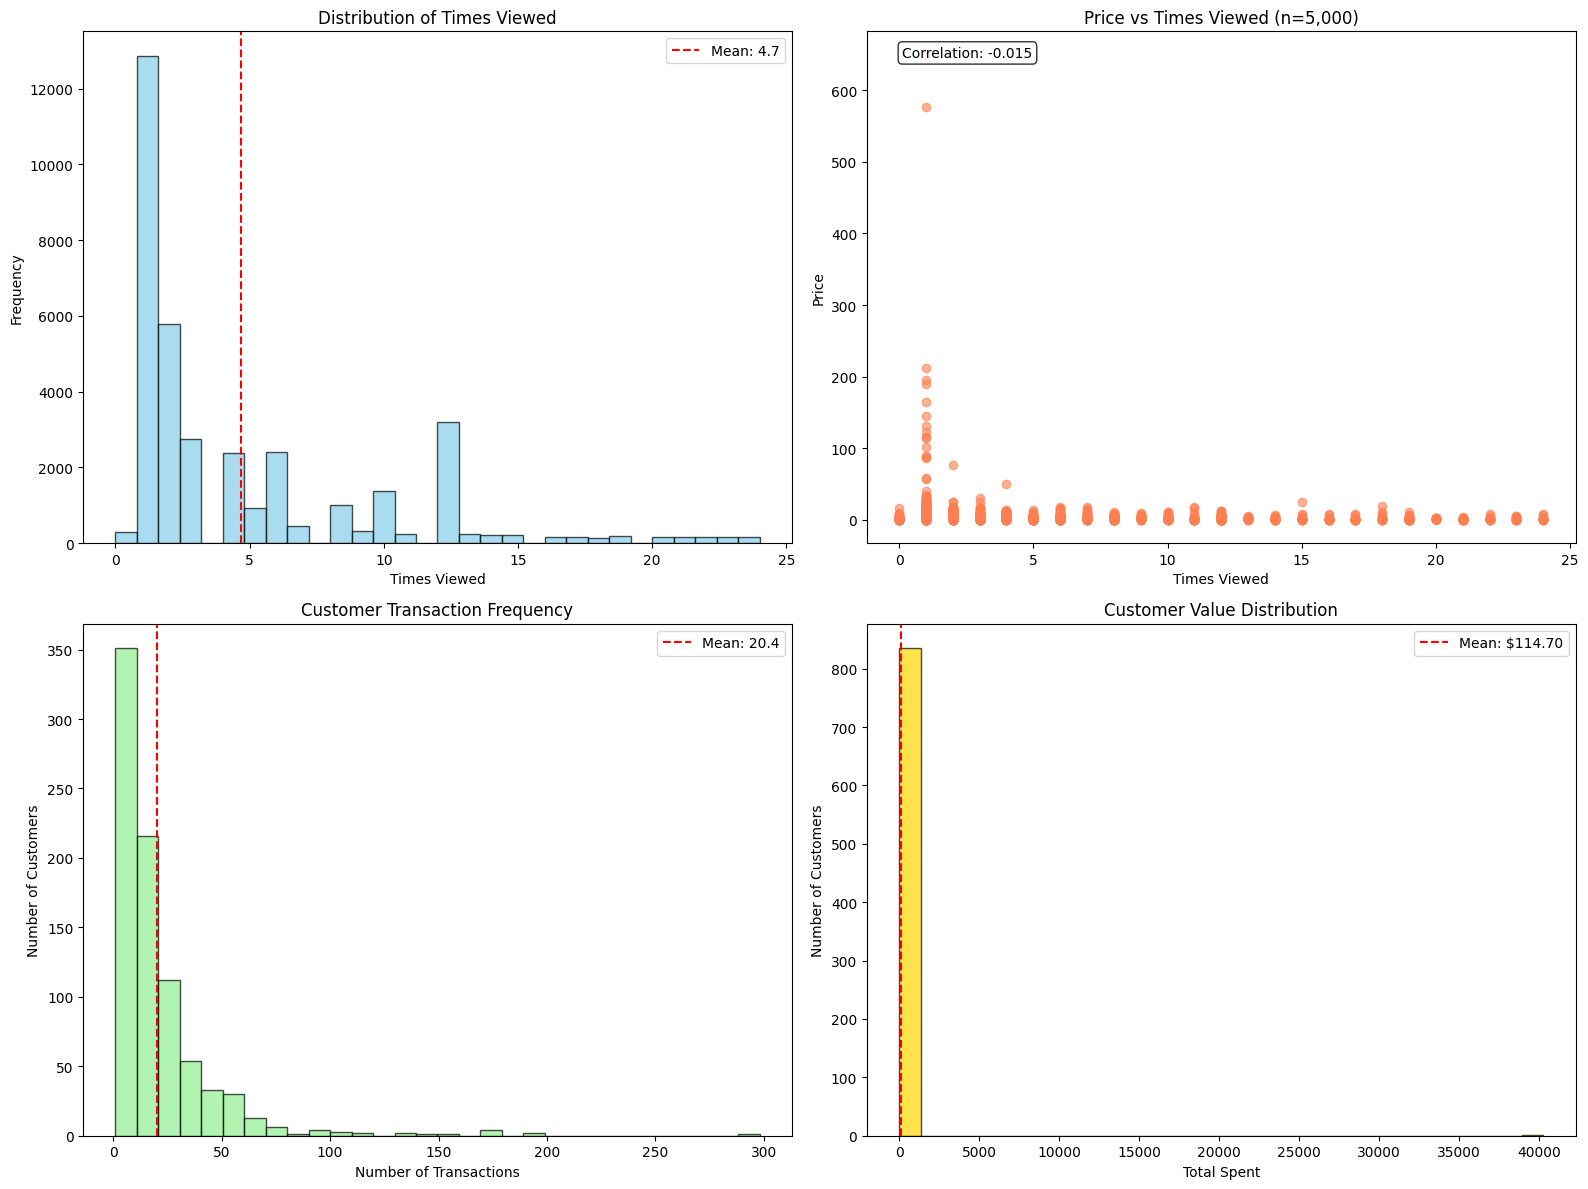


ENGAGEMENT INSIGHTS:
High engagement transactions (top 20%): 6,951
Average price for high engagement: $1.69
Average price overall: $7.46
High price, low engagement transactions: 5,545
Average price: $32.74


In [6]:
# Customer Behavior Analysis
if len(df) > 0:
    print("="*60)
    print("CUSTOMER BEHAVIOR ANALYSIS")
    print("="*60)
    
    # Customer engagement analysis
    if 'times_viewed' in df.columns:
        print("VIEWING BEHAVIOR ANALYSIS:")
        
        # Viewing statistics
        total_views = df['times_viewed'].sum()
        avg_views_per_transaction = df['times_viewed'].mean()
        
        print(f"Total Views: {total_views:,}")
        print(f"Average Views per Transaction: {avg_views_per_transaction:.2f}")
        
        # Viewing distribution
        view_categories = pd.cut(df['times_viewed'], 
                               bins=[0, 1, 5, 10, 20, float('inf')],
                               labels=['1 view', '2-5 views', '6-10 views', '11-20 views', '20+ views'],
                               include_lowest=True)
        
        view_distribution = view_categories.value_counts()
        print(f"\nViewing Distribution:")
        for category, count in view_distribution.items():
            percentage = (count / len(df)) * 100
            print(f"    {category}: {count:,} ({percentage:.1f}%)")
    
    # Customer frequency analysis
    if 'customer_id' in df.columns:
        # Remove null customer IDs for analysis
        customer_data = df[df['customer_id'].notna()].copy()
        
        if len(customer_data) > 0:
            print(f"\nCUSTOMER FREQUENCY ANALYSIS:")
            print(f"Customers with IDs: {len(customer_data):,} transactions")
            print(f"Unique Customers: {customer_data['customer_id'].nunique():,}")
            
            # Customer transaction frequency
            customer_frequency = customer_data.groupby('customer_id').size()
            print(f"\nTransaction Frequency per Customer:")
            print(f"Average: {customer_frequency.mean():.2f}")
            print(f"Median: {customer_frequency.median():.2f}")
            print(f"Max: {customer_frequency.max()}")
            
            # Customer value analysis
            customer_value = customer_data.groupby('customer_id').agg({
                'price': ['sum', 'mean', 'count'],
                'times_viewed': 'sum' if 'times_viewed' in df.columns else 'count'
            })
            
            customer_value.columns = ['Total_Spent', 'Avg_Price', 'Transaction_Count', 'Total_Views']
            customer_value = customer_value.sort_values('Total_Spent', ascending=False)
            
            print(f"\nTOP 10 CUSTOMERS BY VALUE:")
            display(customer_value.head(10))
            
            # Customer segmentation
            # Define segments based on total spent
            q75 = customer_value['Total_Spent'].quantile(0.75)
            q50 = customer_value['Total_Spent'].quantile(0.50)
            q25 = customer_value['Total_Spent'].quantile(0.25)
            
            customer_value['Segment'] = pd.cut(customer_value['Total_Spent'],
                                             bins=[0, q25, q50, q75, float('inf')],
                                             labels=['Low Value', 'Medium Value', 'High Value', 'Premium'],
                                             include_lowest=True)
            
            segment_analysis = customer_value.groupby('Segment').agg({
                'Total_Spent': ['count', 'sum', 'mean'],
                'Transaction_Count': 'mean',
                'Total_Views': 'mean'
            }).round(2)
            
            print(f"\nCUSTOMER SEGMENTATION:")
            display(segment_analysis)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Times viewed distribution
    if 'times_viewed' in df.columns:
        axes[0, 0].hist(df['times_viewed'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, 0].set_title('Distribution of Times Viewed')
        axes[0, 0].set_xlabel('Times Viewed')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].axvline(df['times_viewed'].mean(), color='red', linestyle='--', 
                          label=f'Mean: {df["times_viewed"].mean():.1f}')
        axes[0, 0].legend()
    
    # Price vs Times Viewed scatter plot
    if 'times_viewed' in df.columns and 'price' in df.columns:
        sample_size = min(5000, len(df))  # Sample for better performance
        sample_df = df.sample(sample_size) if len(df) > sample_size else df
        
        axes[0, 1].scatter(sample_df['times_viewed'], sample_df['price'], 
                          alpha=0.6, color='coral')
        axes[0, 1].set_title(f'Price vs Times Viewed (n={len(sample_df):,})')
        axes[0, 1].set_xlabel('Times Viewed')
        axes[0, 1].set_ylabel('Price')
        
        # Add correlation
        correlation = df['price'].corr(df['times_viewed'])
        axes[0, 1].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                       transform=axes[0, 1].transAxes, 
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Customer frequency distribution
    if 'customer_id' in df.columns and len(customer_data) > 0:
        axes[1, 0].hist(customer_frequency, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[1, 0].set_title('Customer Transaction Frequency')
        axes[1, 0].set_xlabel('Number of Transactions')
        axes[1, 0].set_ylabel('Number of Customers')
        axes[1, 0].axvline(customer_frequency.mean(), color='red', linestyle='--',
                          label=f'Mean: {customer_frequency.mean():.1f}')
        axes[1, 0].legend()
        
        # Customer value distribution
        axes[1, 1].hist(customer_value['Total_Spent'], bins=30, alpha=0.7, 
                       color='gold', edgecolor='black')
        axes[1, 1].set_title('Customer Value Distribution')
        axes[1, 1].set_xlabel('Total Spent')
        axes[1, 1].set_ylabel('Number of Customers')
        axes[1, 1].axvline(customer_value['Total_Spent'].mean(), color='red', linestyle='--',
                          label=f'Mean: ${customer_value["Total_Spent"].mean():.2f}')
        axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Engagement insights
    if 'times_viewed' in df.columns and 'price' in df.columns:
        print(f"\nENGAGEMENT INSIGHTS:")
        
        # High engagement transactions
        high_engagement = df[df['times_viewed'] > df['times_viewed'].quantile(0.8)]
        print(f"High engagement transactions (top 20%): {len(high_engagement):,}")
        print(f"Average price for high engagement: ${high_engagement['price'].mean():.2f}")
        print(f"Average price overall: ${df['price'].mean():.2f}")
        
        # Low engagement but high price
        high_price_low_engagement = df[(df['price'] > df['price'].quantile(0.8)) & 
                                      (df['times_viewed'] <= 2)]
        print(f"High price, low engagement transactions: {len(high_price_low_engagement):,}")
        
        if len(high_price_low_engagement) > 0:
            print(f"Average price: ${high_price_low_engagement['price'].mean():.2f}")

else:
    print("No data available for customer behavior analysis")

## 7. Product Stream Performance Analysis

Let's analyze the performance of different product streams to identify top-performing categories and pricing strategies.

PRODUCT STREAM PERFORMANCE ANALYSIS
TOTAL UNIQUE STREAMS: 3,552

TOP 20 STREAMS BY REVENUE:


,Total_Revenue,Avg_Price,Transaction_Count,Price_Std,Total_Views,Avg_Views,Unique_Customers,Revenue_per_Customer,Views_per_Transaction
stream_id,,,,,,,,,
AMAZONFEE,59699.75,11939.95,5,5203.74,7,1.40,0,inf,1.40
M,43428.75,2068.04,21,8459.67,34,1.62,11,3948.07,1.62
DOT,22882.67,243.43,94,198.60,94,1.00,0,inf,1.00
22423,1989.35,14.74,135,5.32,549,4.07,89,22.35,4.07
22502,1688.44,33.77,50,126.98,149,2.98,10,168.84,2.98
POST,1310.35,20.16,65,8.40,187,2.88,50,26.21,2.88
22655,1105.50,221.10,5,88.55,5,1.00,3,368.50,1.00
84078A,952.53,56.03,17,16.31,34,2.00,6,158.76,2.00
47566,816.54,6.53,125,2.52,670,5.36,73,11.19,5.36



PERFORMANCE BY STREAM CATEGORY:


,Total_Revenue,Avg_Price,Transaction_Count,Total_Views
stream_category,,,,
Alphanumeric,122970.14,24.94,4931,19222
Numeric,120603.25,3.92,30785,148563
Special,24193.02,152.16,159,281
Other,1732.98,6.85,253,554



PRICING ANALYSIS:
Price Range: $0.00 - $38970.00

HIGH-VALUE STREAMS (top 20% by avg price): 702
Average price: $33.32
Revenue contribution: $194494.54


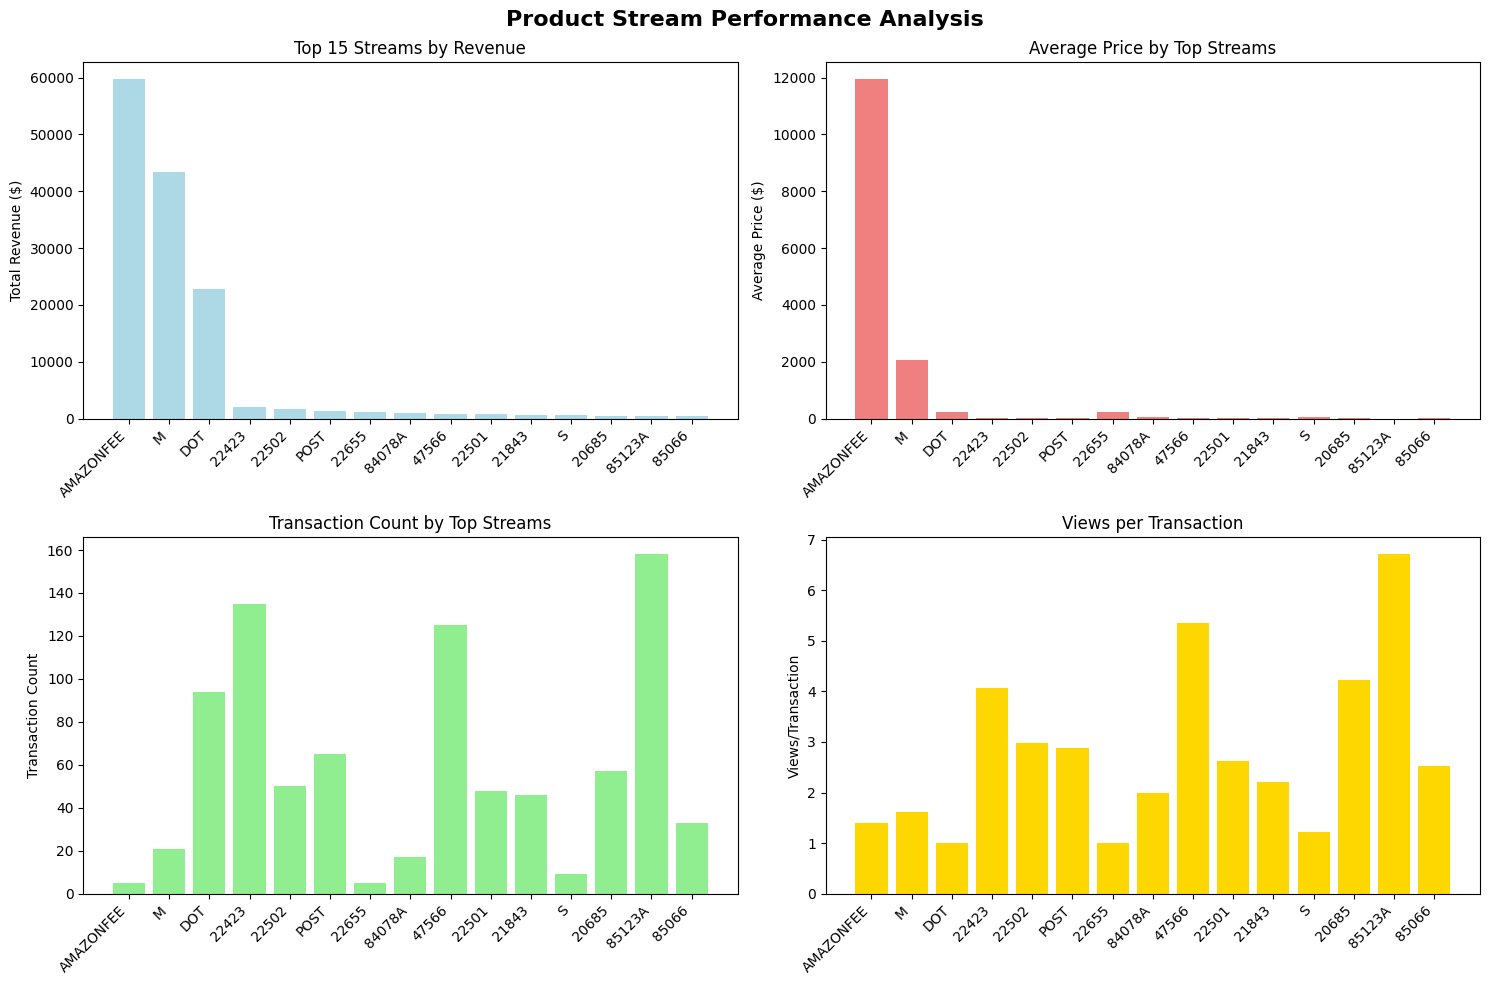


STREAM CONCENTRATION ANALYSIS:
Total streams contributing to 80% of revenue: 518 (14.6% of all streams)
Top 10 streams revenue share: 50.0%
Top 50 streams revenue share: 56.0%


In [7]:
print("============================================================")
print("PRODUCT STREAM PERFORMANCE ANALYSIS")
print("============================================================")

if 'stream_id' in df.columns:
    # Analyze performance by individual streams
    stream_performance = df.groupby('stream_id').agg({
        'price': ['sum', 'mean', 'count', 'std'],
        'times_viewed': ['sum', 'mean'] if 'times_viewed' in df.columns else ['count', 'mean'],
        'customer_id': 'nunique' if 'customer_id' in df.columns else 'count'
    }).round(2)
    
    # Flatten column names
    stream_performance.columns = ['Total_Revenue', 'Avg_Price', 'Transaction_Count', 
                                 'Price_Std', 'Total_Views', 'Avg_Views', 'Unique_Customers']
    
    # Calculate additional metrics
    stream_performance['Revenue_per_Customer'] = (stream_performance['Total_Revenue'] / 
                                                 stream_performance['Unique_Customers']).round(2)
    stream_performance['Views_per_Transaction'] = (stream_performance['Total_Views'] / 
                                                  stream_performance['Transaction_Count']).round(2)
    
    # Sort by total revenue
    stream_performance = stream_performance.sort_values('Total_Revenue', ascending=False)
    
    print(f"TOTAL UNIQUE STREAMS: {len(stream_performance):,}")
    print(f"\nTOP 20 STREAMS BY REVENUE:")
    display(stream_performance.head(20))
    
    # Stream categories analysis (basic categorization by numeric patterns)
    df['stream_category'] = 'Other'
    
    # Categorize streams based on ID patterns
    df.loc[df['stream_id'].str.match(r'^\d+$', na=False), 'stream_category'] = 'Numeric'
    df.loc[df['stream_id'].str.contains(r'[A-Z]', na=False), 'stream_category'] = 'Alphanumeric'
    df.loc[df['stream_id'].str.upper() == 'DOT', 'stream_category'] = 'Special'
    df.loc[df['stream_id'].str.upper() == 'POST', 'stream_category'] = 'Special'
    
    category_performance = df.groupby('stream_category').agg({
        'price': ['sum', 'mean', 'count'],
        'times_viewed': 'sum' if 'times_viewed' in df.columns else 'count'
    }).round(2)
    
    category_performance.columns = ['Total_Revenue', 'Avg_Price', 'Transaction_Count', 'Total_Views']
    category_performance = category_performance.sort_values('Total_Revenue', ascending=False)
    
    print(f"\nPERFORMANCE BY STREAM CATEGORY:")
    display(category_performance)
    
    # Price analysis by stream
    print(f"\nPRICING ANALYSIS:")
    print(f"Price Range: ${df['price'].min():.2f} - ${df['price'].max():.2f}")
    
    # High-value streams
    high_value_streams = stream_performance[stream_performance['Avg_Price'] > 
                                          stream_performance['Avg_Price'].quantile(0.8)]
    print(f"\nHIGH-VALUE STREAMS (top 20% by avg price): {len(high_value_streams)}")
    if len(high_value_streams) > 0:
        print(f"Average price: ${high_value_streams['Avg_Price'].mean():.2f}")
        print(f"Revenue contribution: ${high_value_streams['Total_Revenue'].sum():.2f}")
    
    # Create visualizations with matplotlib fallback
    top_streams = stream_performance.head(15)
    
    try:
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Top 15 Streams by Revenue', 'Average Price by Top Streams',
                           'Transaction Count by Top Streams', 'Views per Transaction'),
            specs=[[{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": False}]]
        )
        
        # Total Revenue
        fig.add_trace(
            go.Bar(x=top_streams.index, y=top_streams['Total_Revenue'],
                   name='Total Revenue', marker_color='lightblue'),
            row=1, col=1
        )
        
        # Average Price
        fig.add_trace(
            go.Bar(x=top_streams.index, y=top_streams['Avg_Price'],
                   name='Avg Price', marker_color='lightcoral'),
            row=1, col=2
        )
        
        # Transaction Count
        fig.add_trace(
            go.Bar(x=top_streams.index, y=top_streams['Transaction_Count'],
                   name='Transactions', marker_color='lightgreen'),
            row=2, col=1
        )
        
        # Views per Transaction
        if 'times_viewed' in df.columns:
            fig.add_trace(
                go.Bar(x=top_streams.index, y=top_streams['Views_per_Transaction'],
                       name='Views/Transaction', marker_color='gold'),
                row=2, col=2
            )
        
        fig.update_layout(height=800, showlegend=False, title_text="Product Stream Performance Analysis")
        fig.update_xaxes(tickangle=45)
        fig.show()
        
    except Exception as e:
        
        # Matplotlib fallback
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Product Stream Performance Analysis', fontsize=16, fontweight='bold')
        
        # Total Revenue
        ax1.bar(range(len(top_streams)), top_streams['Total_Revenue'], color='lightblue')
        ax1.set_title('Top 15 Streams by Revenue')
        ax1.set_ylabel('Total Revenue ($)')
        ax1.set_xticks(range(len(top_streams)))
        ax1.set_xticklabels(top_streams.index, rotation=45, ha='right')
        
        # Average Price
        ax2.bar(range(len(top_streams)), top_streams['Avg_Price'], color='lightcoral')
        ax2.set_title('Average Price by Top Streams')
        ax2.set_ylabel('Average Price ($)')
        ax2.set_xticks(range(len(top_streams)))
        ax2.set_xticklabels(top_streams.index, rotation=45, ha='right')
        
        # Transaction Count
        ax3.bar(range(len(top_streams)), top_streams['Transaction_Count'], color='lightgreen')
        ax3.set_title('Transaction Count by Top Streams')
        ax3.set_ylabel('Transaction Count')
        ax3.set_xticks(range(len(top_streams)))
        ax3.set_xticklabels(top_streams.index, rotation=45, ha='right')
        
        # Views per Transaction
        if 'times_viewed' in df.columns:
            ax4.bar(range(len(top_streams)), top_streams['Views_per_Transaction'], color='gold')
            ax4.set_title('Views per Transaction')
            ax4.set_ylabel('Views/Transaction')
            ax4.set_xticks(range(len(top_streams)))
            ax4.set_xticklabels(top_streams.index, rotation=45, ha='right')
        else:
            ax4.text(0.5, 0.5, 'Views data not available', ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('Views per Transaction (N/A)')
        
        plt.tight_layout()
        plt.show()
    
    # Stream concentration analysis
    total_streams = len(stream_performance)
    total_revenue = stream_performance['Total_Revenue'].sum()
    
    # Pareto analysis
    stream_performance['Cumulative_Revenue'] = stream_performance['Total_Revenue'].cumsum()
    stream_performance['Cumulative_Percentage'] = (stream_performance['Cumulative_Revenue'] / 
                                                   total_revenue * 100)
    
    # Find 80/20 rule
    pareto_80_streams = len(stream_performance[stream_performance['Cumulative_Percentage'] <= 80])
    pareto_80_percentage = (pareto_80_streams / total_streams) * 100
    
    print(f"\nSTREAM CONCENTRATION ANALYSIS:")
    print(f"Total streams contributing to 80% of revenue: {pareto_80_streams:,} ({pareto_80_percentage:.1f}% of all streams)")
    print(f"Top 10 streams revenue share: {(stream_performance.head(10)['Total_Revenue'].sum() / total_revenue * 100):.1f}%")
    print(f"Top 50 streams revenue share: {(stream_performance.head(50)['Total_Revenue'].sum() / total_revenue * 100):.1f}%")
    
else:
    print("No stream_id column found for product stream analysis")

## 8. Temporal Trends and Seasonality

Now let's analyze time-based patterns to understand seasonal trends, growth patterns, and temporal behaviors in the data.

TEMPORAL TRENDS AND SEASONALITY ANALYSIS
DATA PERIOD: 2017-11-30 to 2019-07-31
TOTAL PERIOD: 608 days (1.7 years)

DAILY TRENDS SUMMARY:
Average daily revenue: $5182.68
Average daily transactions: 695
Peak daily revenue: $43930.55
Peak daily transactions: 1735

MONTHLY TRENDS:
Best month revenue: $63645.04
Worst month revenue: $2607.28
Revenue growth (first to last month): 7.1%

SEASONAL PATTERNS:


,Total_Revenue,Avg_Price,Transaction_Count,Avg_Views
month,,,,
Jan,59449.51,9.71,6121,4.49
Mar,17381.44,4.35,4000,5.82
Apr,5783.86,4.89,1183,3.82
May,49310.94,6.16,8000,5.39
Jun,56328.63,14.08,4000,5.28
Jul,11029.58,3.65,3018,4.55
Oct,3963.11,3.96,1000,5.01
Nov,2607.28,4.07,640,4.24
Dec,63645.04,7.79,8166,3.39



DAY OF WEEK PATTERNS:


,Total_Revenue,Avg_Price,Transaction_Count,Avg_Views
day_of_week,,,,
Monday,64221.35,6.20,10362,4.34
Tuesday,60585.01,7.48,8097,4.16
Wednesday,56303.93,9.40,5987,4.89
Thursday,23894.98,4.54,5260,5.18
Friday,63497.73,10.24,6199,5.18
Sunday,996.39,4.47,223,5.98


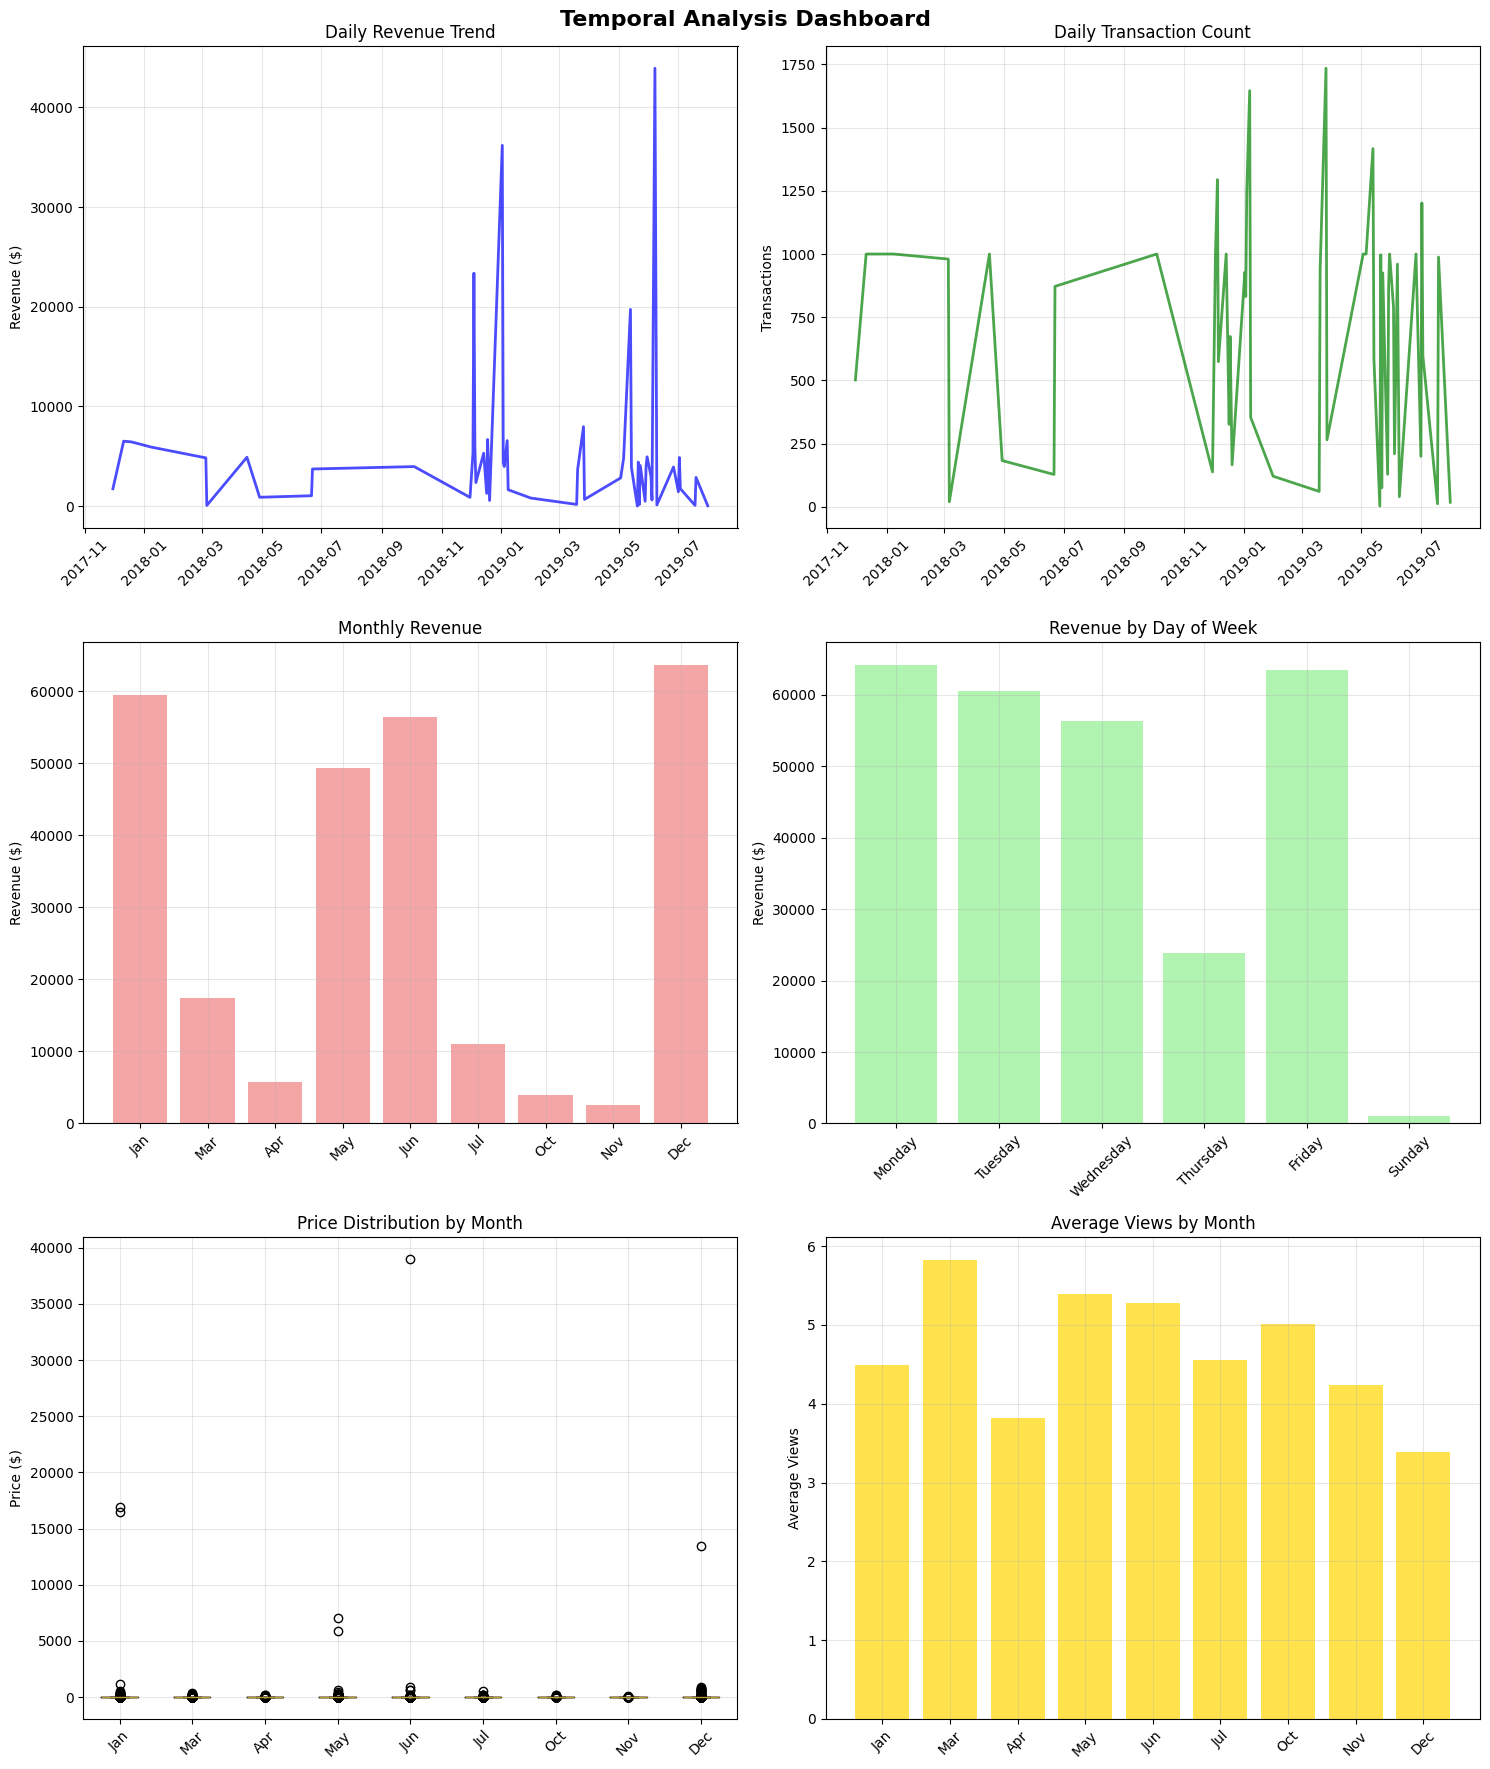


GROWTH ANALYSIS:
Average month-over-month growth: 349.0%
Most volatile month-over-month change: 2341.1%

SEASONAL INSIGHTS:
Best performing day: Monday ($64221.35)
Worst performing day: Sunday ($996.39)
Peak month: Dec ($63645.04)
Slowest month: Nov ($2607.28)
Business Pattern: Primarily weekday operations


In [12]:
print("============================================================")
print("TEMPORAL TRENDS AND SEASONALITY ANALYSIS")
print("============================================================")

if 'date' in df.columns:
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Create temporal features
    # df['date'] = df['date'].dt.date
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek
    df['hour'] = df['date'].dt.hour
    
    # Basic temporal statistics
    date_range = df['date'].max() - df['date'].min()
    
    print(f"DATA PERIOD: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
    print(f"TOTAL PERIOD: {date_range.days} days ({date_range.days/365.25:.1f} years)")
    
    # Daily aggregations
    daily_metrics = df.groupby('date').agg({
        'price': ['sum', 'mean', 'count'],
        'times_viewed': 'sum' if 'times_viewed' in df.columns else 'count'
    }).round(2)
    
    daily_metrics.columns = ['Total_Revenue', 'Avg_Price', 'Transaction_Count', 'Total_Views']
    
    print(f"\nDAILY TRENDS SUMMARY:")
    print(f"Average daily revenue: ${daily_metrics['Total_Revenue'].mean():.2f}")
    print(f"Average daily transactions: {daily_metrics['Transaction_Count'].mean():.0f}")
    print(f"Peak daily revenue: ${daily_metrics['Total_Revenue'].max():.2f}")
    print(f"Peak daily transactions: {daily_metrics['Transaction_Count'].max():.0f}")
    
    # Monthly analysis
    month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                   7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    
    monthly_metrics = df.groupby('month').agg({
        'price': ['sum', 'mean', 'count'],
        'times_viewed': 'mean' if 'times_viewed' in df.columns else 'count'
    }).round(2)
    
    monthly_metrics.columns = ['Total_Revenue', 'Avg_Price', 'Transaction_Count', 'Avg_Views']
    monthly_metrics.index = monthly_metrics.index.map(month_names)
    
    print(f"\nMONTHLY TRENDS:")
    print(f"Best month revenue: ${monthly_metrics['Total_Revenue'].max():.2f}")
    print(f"Worst month revenue: ${monthly_metrics['Total_Revenue'].min():.2f}")
    
    months_in_data = sorted(df['month'].unique())
    if len(months_in_data) > 1:
        first_month_revenue = monthly_metrics.loc[month_names[months_in_data[0]], 'Total_Revenue']
        last_month_revenue = monthly_metrics.loc[month_names[months_in_data[-1]], 'Total_Revenue']
        growth_rate = ((last_month_revenue - first_month_revenue) / first_month_revenue) * 100
        print(f"Revenue growth (first to last month): {growth_rate:.1f}%")
    
    print(f"\nSEASONAL PATTERNS:")
    display(monthly_metrics)
    
    # Day of week analysis
    dow_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
                 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    
    dow_analysis = df.groupby('day_of_week').agg({
        'price': ['sum', 'mean', 'count'],
        'times_viewed': 'mean' if 'times_viewed' in df.columns else 'count'
    }).round(2)
    
    dow_analysis.columns = ['Total_Revenue', 'Avg_Price', 'Transaction_Count', 'Avg_Views']
    dow_analysis.index = dow_analysis.index.map(dow_names)
    
    print(f"\nDAY OF WEEK PATTERNS:")
    display(dow_analysis)
    
    # Create comprehensive temporal dashboard with matplotlib
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 18))
    fig.suptitle('Temporal Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # Daily revenue trend
    daily_metrics_sorted = daily_metrics.reset_index().sort_values('date')
    ax1.plot(daily_metrics_sorted['date'], daily_metrics_sorted['Total_Revenue'], 
             linewidth=2, color='blue', alpha=0.7)
    ax1.set_title('Daily Revenue Trend')
    ax1.set_ylabel('Revenue ($)')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Daily transaction count
    ax2.plot(daily_metrics_sorted['date'], daily_metrics_sorted['Transaction_Count'], 
             linewidth=2, color='green', alpha=0.7)
    ax2.set_title('Daily Transaction Count')
    ax2.set_ylabel('Transactions')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # Monthly revenue bars
    monthly_data = monthly_metrics.reset_index()
    ax3.bar(monthly_data.index, monthly_data['Total_Revenue'], 
            color='lightcoral', alpha=0.7)
    ax3.set_title('Monthly Revenue')
    ax3.set_ylabel('Revenue ($)')
    ax3.set_xticks(monthly_data.index)
    ax3.set_xticklabels(monthly_data['month'], rotation=45)
    ax3.grid(True, alpha=0.3)
    
    # Day of week analysis
    dow_data = dow_analysis.reset_index()
    ax4.bar(dow_data.index, dow_data['Total_Revenue'], 
            color='lightgreen', alpha=0.7)
    ax4.set_title('Revenue by Day of Week')
    ax4.set_ylabel('Revenue ($)')
    ax4.set_xticks(dow_data.index)
    ax4.set_xticklabels(dow_data['day_of_week'], rotation=45)
    ax4.grid(True, alpha=0.3)
    
    # Price distribution over time (monthly)
    monthly_prices = []
    month_labels = []
    for month in sorted(df['month'].unique()):
        prices = df[df['month'] == month]['price']
        if len(prices) > 0:
            monthly_prices.append(prices)
            month_labels.append(month_names[month])
    
    if monthly_prices:
        ax5.boxplot(monthly_prices, labels=month_labels)
        ax5.set_title('Price Distribution by Month')
        ax5.set_ylabel('Price ($)')
        ax5.tick_params(axis='x', rotation=45)
        ax5.grid(True, alpha=0.3)
    else:
        ax5.text(0.5, 0.5, 'No price data available', ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Price Distribution by Month (N/A)')
    
    # Average views by month (if available)
    if 'times_viewed' in df.columns:
        ax6.bar(monthly_data.index, monthly_data['Avg_Views'], 
                color='gold', alpha=0.7)
        ax6.set_title('Average Views by Month')
        ax6.set_ylabel('Average Views')
        ax6.set_xticks(monthly_data.index)
        ax6.set_xticklabels(monthly_data['month'], rotation=45)
        ax6.grid(True, alpha=0.3)
    else:
        ax6.text(0.5, 0.5, 'Views data not available', ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('Average Views by Month (N/A)')
    
    plt.tight_layout()
    plt.show()
    
    # Growth analysis
    if len(monthly_metrics) > 1:
        revenue_trend = monthly_metrics['Total_Revenue'].values
        month_over_month = []
        
        for i in range(1, len(revenue_trend)):
            if revenue_trend[i-1] != 0:
                growth = ((revenue_trend[i] - revenue_trend[i-1]) / revenue_trend[i-1]) * 100
                month_over_month.append(growth)
        
        if month_over_month:
            print(f"\nGROWTH ANALYSIS:")
            print(f"Average month-over-month growth: {np.mean(month_over_month):.1f}%")
            print(f"Most volatile month-over-month change: {max(month_over_month, key=abs):.1f}%")
    
    # Seasonal insights
    print(f"\nSEASONAL INSIGHTS:")
    
    # Best and worst performing days
    best_day = dow_analysis['Total_Revenue'].idxmax()
    worst_day = dow_analysis['Total_Revenue'].idxmin()
    print(f"Best performing day: {best_day} (${dow_analysis.loc[best_day, 'Total_Revenue']:.2f})")
    print(f"Worst performing day: {worst_day} (${dow_analysis.loc[worst_day, 'Total_Revenue']:.2f})")
    
    # Best and worst months
    best_month = monthly_metrics['Total_Revenue'].idxmax()
    worst_month = monthly_metrics['Total_Revenue'].idxmin()
    print(f"Peak month: {best_month} (${monthly_metrics.loc[best_month, 'Total_Revenue']:.2f})")
    print(f"Slowest month: {worst_month} (${monthly_metrics.loc[worst_month, 'Total_Revenue']:.2f})")
    
    # Weekly patterns
    weekday_revenue = dow_analysis.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 'Total_Revenue'].sum()
    weekend_revenue = dow_analysis.loc[['Saturday', 'Sunday'], 'Total_Revenue'].sum() if 'Saturday' in dow_analysis.index else 0
    
    if weekend_revenue > 0:
        weekend_ratio = (weekend_revenue / (weekday_revenue + weekend_revenue)) * 100
        print(f"Weekend vs Weekday: {weekend_ratio:.1f}% of revenue comes from weekends")
    else:
        print(f"Business Pattern: Primarily weekday operations")

else:
    print("No date column found for temporal analysis")

## 9. Price Distribution and Revenue Impact

Let's analyze pricing strategies, price distributions, and their impact on revenue and customer engagement.

GEOGRAPHIC REVENUE ANALYSIS
REVENUE BY COUNTRY (Top 15):


,Total_Revenue,Avg_Price,Transaction_Count,Total_Views,Unique_Customers,Market_Share,Revenue_per_Customer,Revenue_per_Transaction
country,,,,,,,,
United Kingdom,259244.78,7.71,33626,147603,750,96.19,345.66,7.71
Spain,2183.39,8.12,269,1473,8,0.81,272.92,8.12
EIRE,2120.62,3.98,533,4254,3,0.79,706.87,3.98
Germany,1677.43,3.72,451,3698,22,0.62,76.25,3.72
France,1314.38,3.84,342,2969,17,0.49,77.32,3.84
Greece,591.64,3.38,175,1303,1,0.22,591.64,3.38
Netherlands,587.65,2.80,210,2387,4,0.22,146.91,2.80
Switzerland,288.46,3.65,79,850,2,0.11,144.23,3.65
Norway,273.59,2.94,93,972,2,0.10,136.79,2.94



GEOGRAPHIC MARKET SUMMARY:
Total Countries: 20
Total Revenue: $269,499.39
Top 5 Countries Revenue Share: 98.9%
Primary Market: United Kingdom ($259,244.78)


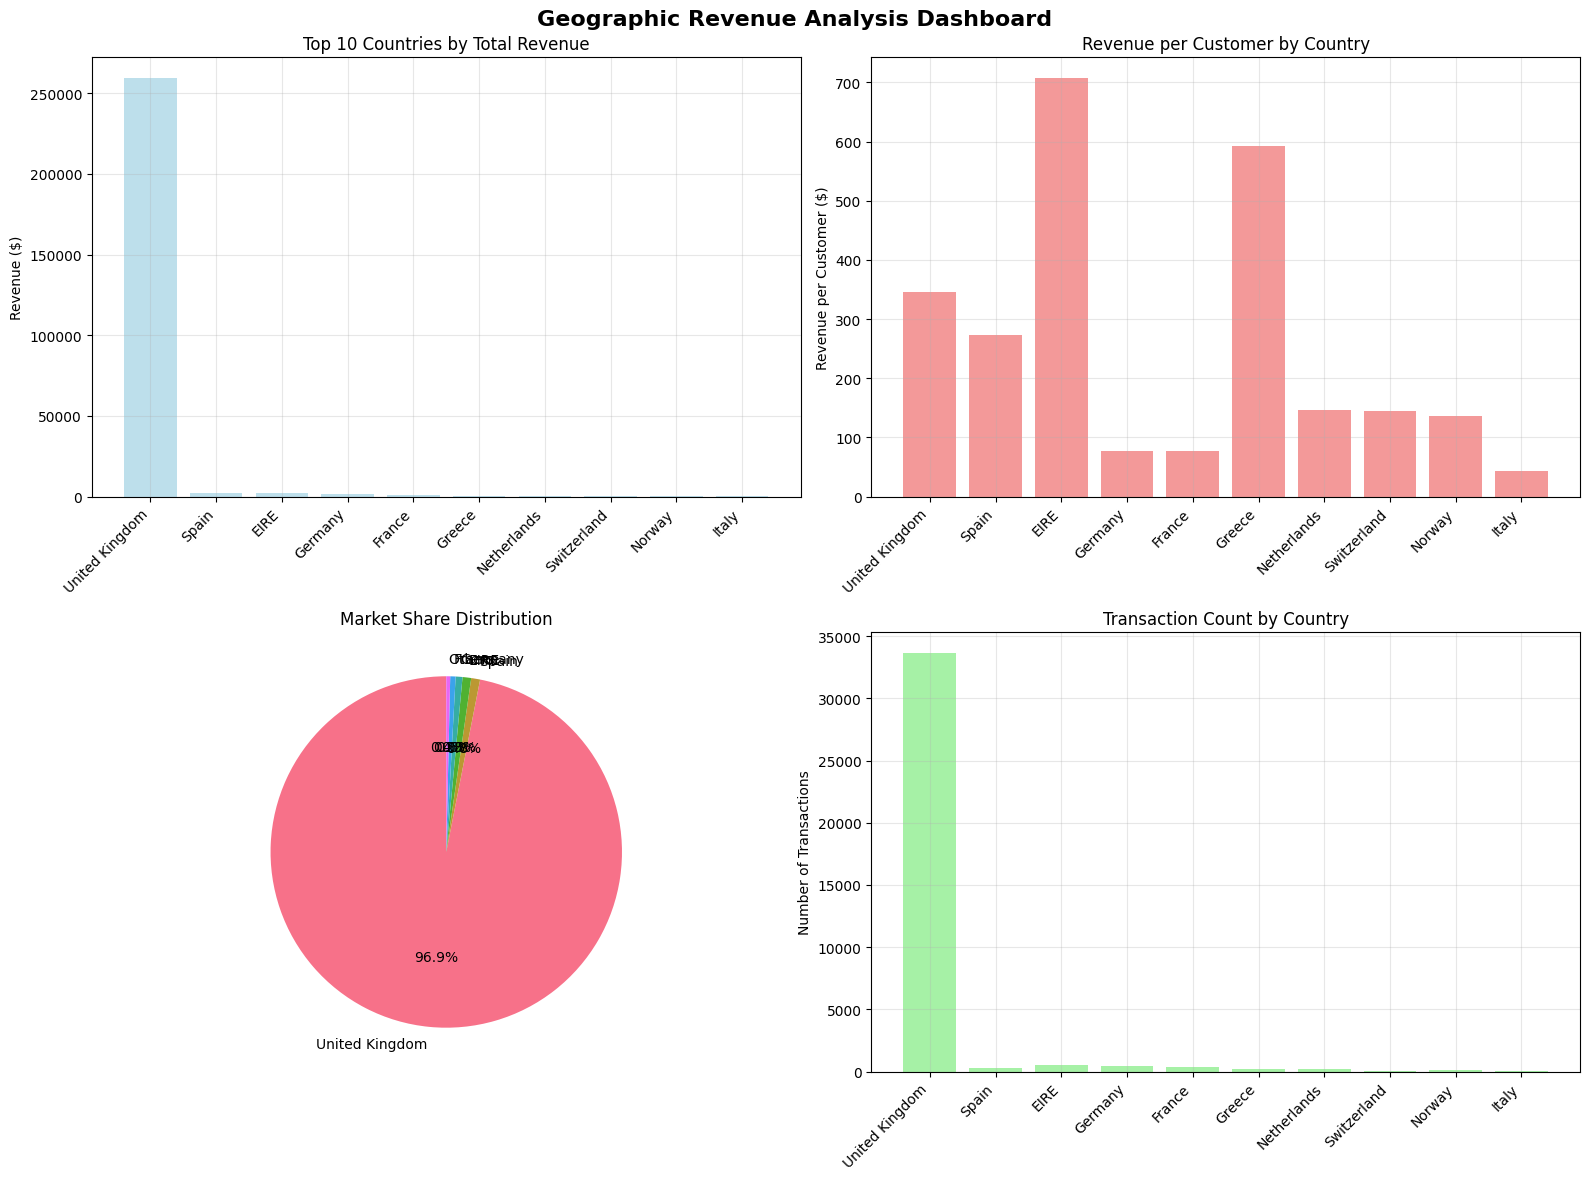


MARKET PERFORMANCE INSIGHTS:
High-Value Markets (0 countries with above average revenue per customer):

High-Volume Markets (1 countries with above average transactions):
- United Kingdom: 33,626 transactions

MARKET EFFICIENCY ANALYSIS:
Most Efficient (highest revenue per transaction):
- European Community: $9.62 per transaction
- Spain: $8.12 per transaction
- United Kingdom: $7.71 per transaction

Growth Opportunities (high volume, lower efficiency):

ENGAGEMENT BY COUNTRY:
Australia: 11.7 views per transaction
Netherlands: 11.4 views per transaction
Switzerland: 10.8 views per transaction
Finland: 10.6 views per transaction
Norway: 10.4 views per transaction


In [14]:
print("============================================================")
print("GEOGRAPHIC REVENUE ANALYSIS")
print("============================================================")

if 'country' in df.columns and len(df) > 0:
    # Country-wise revenue analysis
    country_revenue = df.groupby('country').agg({
        'price': ['sum', 'mean', 'count'],
        'times_viewed': 'sum' if 'times_viewed' in df.columns else 'count',
        'customer_id': 'nunique' if 'customer_id' in df.columns else 'count'
    }).round(2)
    
    # Flatten column names
    country_revenue.columns = ['Total_Revenue', 'Avg_Price', 'Transaction_Count', 'Total_Views', 'Unique_Customers']
    
    # Calculate additional metrics
    country_revenue['Market_Share'] = (country_revenue['Total_Revenue'] / country_revenue['Total_Revenue'].sum() * 100).round(2)
    country_revenue['Revenue_per_Customer'] = (country_revenue['Total_Revenue'] / country_revenue['Unique_Customers']).round(2)
    country_revenue['Revenue_per_Transaction'] = (country_revenue['Total_Revenue'] / country_revenue['Transaction_Count']).round(2)
    
    # Sort by revenue
    country_revenue = country_revenue.sort_values('Total_Revenue', ascending=False)
    
    print(f"REVENUE BY COUNTRY (Top 15):")
    display(country_revenue.head(15))
    
    # Geographic insights
    total_countries = len(country_revenue)
    total_revenue = country_revenue['Total_Revenue'].sum()
    
    print(f"\nGEOGRAPHIC MARKET SUMMARY:")
    print(f"Total Countries: {total_countries}")
    print(f"Total Revenue: ${total_revenue:,.2f}")
    
    # Top markets analysis
    top_5_revenue = country_revenue.head(5)['Total_Revenue'].sum()
    top_5_share = (top_5_revenue / total_revenue * 100)
    
    print(f"Top 5 Countries Revenue Share: {top_5_share:.1f}%")
    print(f"Primary Market: {country_revenue.index[0]} (${country_revenue.iloc[0]['Total_Revenue']:,.2f})")
    
    # Market concentration analysis
    top_10_countries = country_revenue.head(10)
    others_revenue = total_revenue - top_10_countries['Total_Revenue'].sum()
    
    # Create comprehensive geographic visualization with matplotlib
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Geographic Revenue Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # Top 10 countries revenue bar chart
    top_10_rev_per_customer = top_10_countries.copy()
    ax1.bar(range(len(top_10_rev_per_customer)), top_10_rev_per_customer['Total_Revenue'], 
            color='lightblue', alpha=0.8)
    ax1.set_title('Top 10 Countries by Total Revenue')
    ax1.set_ylabel('Revenue ($)')
    ax1.set_xticks(range(len(top_10_rev_per_customer)))
    ax1.set_xticklabels(top_10_rev_per_customer.index, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    
    # Revenue per customer
    ax2.bar(range(len(top_10_rev_per_customer)), top_10_rev_per_customer['Revenue_per_Customer'], 
            color='lightcoral', alpha=0.8)
    ax2.set_title('Revenue per Customer by Country')
    ax2.set_ylabel('Revenue per Customer ($)')
    ax2.set_xticks(range(len(top_10_rev_per_customer)))
    ax2.set_xticklabels(top_10_rev_per_customer.index, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    # Market share pie chart (top 5 + others)
    top_countries = country_revenue.head(5)
    pie_data = list(top_countries['Total_Revenue']) + [others_revenue] if others_revenue > 0 else list(top_countries['Total_Revenue'])
    pie_labels = list(top_countries.index) + ['Others'] if others_revenue > 0 else list(top_countries.index)
    
    ax3.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
    ax3.set_title('Market Share Distribution')
    
    # Transaction count by country
    ax4.bar(range(len(top_10_rev_per_customer)), top_10_rev_per_customer['Transaction_Count'], 
            color='lightgreen', alpha=0.8)
    ax4.set_title('Transaction Count by Country')
    ax4.set_ylabel('Number of Transactions')
    ax4.set_xticks(range(len(top_10_rev_per_customer)))
    ax4.set_xticklabels(top_10_rev_per_customer.index, rotation=45, ha='right')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Market performance insights
    print(f"\nMARKET PERFORMANCE INSIGHTS:")
    
    # High-value markets
    avg_revenue_per_customer = country_revenue['Revenue_per_Customer'].mean()
    high_value_markets = country_revenue[country_revenue['Revenue_per_Customer'] > avg_revenue_per_customer]
    
    print(f"High-Value Markets ({len(high_value_markets)} countries with above average revenue per customer):")
    for country in high_value_markets.head(5).index:
        rev_per_customer = high_value_markets.loc[country, 'Revenue_per_Customer']
        print(f"- {country}: ${rev_per_customer:.2f} per customer")
    
    # Large volume markets
    avg_transactions = country_revenue['Transaction_Count'].mean()
    high_volume_markets = country_revenue[country_revenue['Transaction_Count'] > avg_transactions]
    
    print(f"\nHigh-Volume Markets ({len(high_volume_markets)} countries with above average transactions):")
    for country in high_volume_markets.head(5).index:
        transactions = high_volume_markets.loc[country, 'Transaction_Count']
        print(f"- {country}: {transactions:,} transactions")
    
    # Market efficiency analysis
    print(f"\nMARKET EFFICIENCY ANALYSIS:")
    print(f"Most Efficient (highest revenue per transaction):")
    most_efficient = country_revenue.nlargest(3, 'Revenue_per_Transaction')
    for country in most_efficient.index:
        efficiency = most_efficient.loc[country, 'Revenue_per_Transaction']
        print(f"- {country}: ${efficiency:.2f} per transaction")
    
    print(f"\nGrowth Opportunities (high volume, lower efficiency):")
    # Find countries with high transaction count but lower revenue per transaction
    median_efficiency = country_revenue['Revenue_per_Transaction'].median()
    growth_markets = country_revenue[
        (country_revenue['Transaction_Count'] > avg_transactions) & 
        (country_revenue['Revenue_per_Transaction'] < median_efficiency)
    ]
    
    for country in growth_markets.head(3).index:
        transactions = growth_markets.loc[country, 'Transaction_Count']
        efficiency = growth_markets.loc[country, 'Revenue_per_Transaction']
        print(f"- {country}: {transactions:,} transactions, ${efficiency:.2f} per transaction")
    
    if 'times_viewed' in df.columns:
        # Engagement analysis by country
        print(f"\nENGAGEMENT BY COUNTRY:")
        country_engagement = country_revenue.copy()
        country_engagement['Views_per_Transaction'] = (country_engagement['Total_Views'] / 
                                                      country_engagement['Transaction_Count']).round(2)
        
        high_engagement = country_engagement.nlargest(5, 'Views_per_Transaction')
        for country in high_engagement.index:
            engagement = high_engagement.loc[country, 'Views_per_Transaction']
            print(f"{country}: {engagement:.1f} views per transaction")

else:
    if 'country' not in df.columns:
        print("Country data not available for geographic analysis")
    else:
        print("No data available for geographic analysis")

## 10. Correlation Analysis
Understanding relationships between numerical variables to identify business drivers and optimization opportunities.

CUSTOMER BEHAVIOR AND SEGMENTATION ANALYSIS
CUSTOMER OVERVIEW:
Total Customers: 836
Average Customer Value: $114.70
Average Order Value: $14.94
Average Transactions per Customer: 20.4

CUSTOMER SEGMENTATION ANALYSIS:


,Customer_Count,Total_Revenue,Avg_Customer_Value,Avg_Frequency,Avg_Order_Value,Revenue_Share
Segment,,,,,,
High Value,34,45920.58,1350.61,19.65,286.51,47.9
Loyal,39,2721.75,69.79,35.69,1.97,2.8
Standard,629,20510.85,32.61,10.48,3.52,21.4
VIP,134,26735.31,199.52,62.45,3.43,27.9



CUSTOMER FREQUENCY DISTRIBUTION:
One-time customers: 79 (9.4%)
Repeat customers: 757 (90.6%)
Highly loyal customers (6+ purchases): 615 (73.6%)


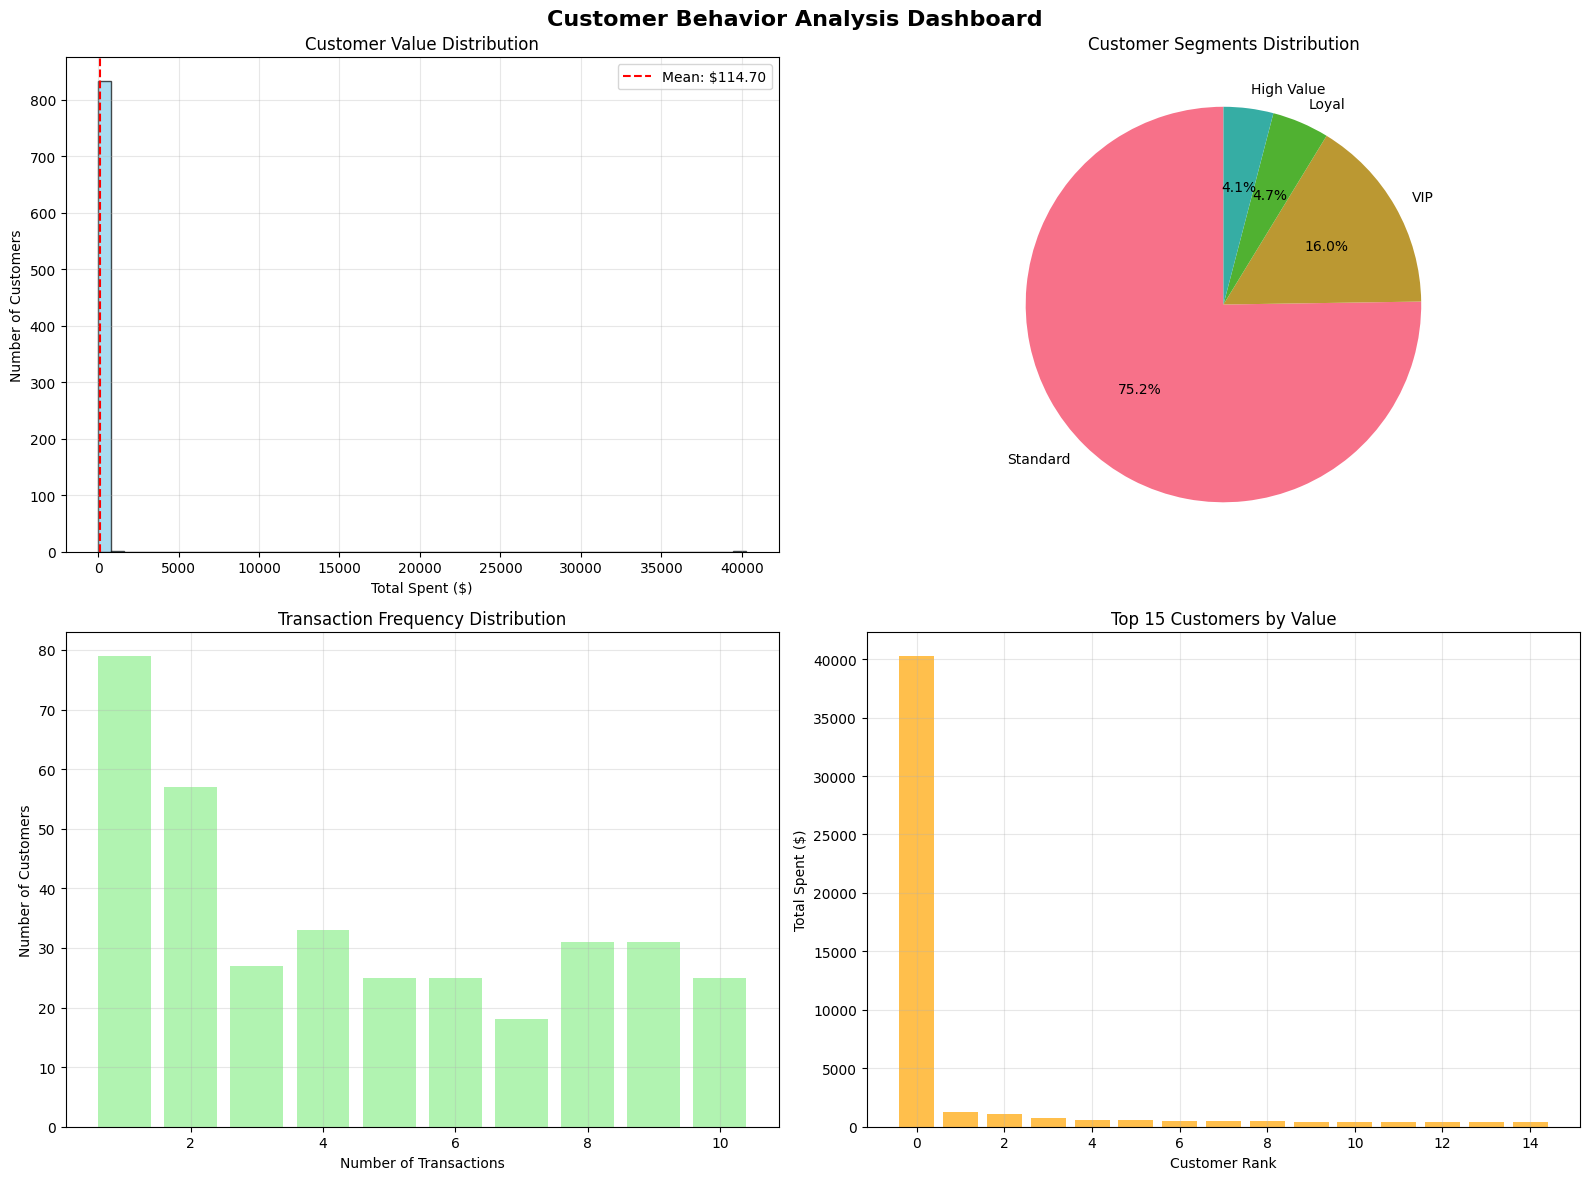


CUSTOMER INSIGHTS:
Top 5 Customers by Value:
  1. Customer 15098.0: $40278.90 (5 transactions)
  2. Customer 14911.0: $1222.87 (298 transactions)
  3. Customer 12503.0: $1126.00 (1 transactions)
  4. Customer 17406.0: $769.86 (38 transactions)
  5. Customer 12511.0: $591.64 (175 transactions)

Revenue Concentration: 75.7% of revenue from top 20% customers

Customer Engagement:
- Average views per customer: 145.9
- High-engagement customers: 148 (17.7%)
- Revenue from high-engagement customers: $24388.91 (25.4%)


In [18]:
print("============================================================")
print("CUSTOMER BEHAVIOR AND SEGMENTATION ANALYSIS")
print("============================================================")

if 'customer_id' in df.columns and len(df) > 0:
    # Customer-level aggregations
    customer_data = df.groupby('customer_id').agg({
        'price': ['sum', 'mean', 'count'],
        'times_viewed': 'sum' if 'times_viewed' in df.columns else 'count',
        'date': ['min', 'max'] if 'date' in df.columns else 'count'
    }).round(2)
    
    # Flatten column names
    if 'date' in df.columns:
        customer_data.columns = ['Total_Spent', 'Avg_Order_Value', 'Transaction_Count', 
                               'Total_Views', 'First_Purchase', 'Last_Purchase']
    else:
        customer_data.columns = ['Total_Spent', 'Avg_Order_Value', 'Transaction_Count', 'Total_Views']
    
    # Customer value segmentation
    customer_value = customer_data.copy()
    
    # Calculate additional metrics
    customer_value['Revenue_Rank'] = customer_value['Total_Spent'].rank(method='dense', ascending=False)
    customer_value['Frequency_Rank'] = customer_value['Transaction_Count'].rank(method='dense', ascending=False)
    
    if 'times_viewed' in df.columns:
        customer_value['Engagement_Score'] = customer_value['Total_Views'] / customer_value['Transaction_Count']
    
    # Customer segments based on value and frequency
    # High Value: Top 20% by revenue
    # High Frequency: Top 20% by transaction count
    
    high_value_threshold = customer_value['Total_Spent'].quantile(0.8)
    high_freq_threshold = customer_value['Transaction_Count'].quantile(0.8)
    
    customer_value['Segment'] = 'Standard'
    customer_value.loc[
        (customer_value['Total_Spent'] >= high_value_threshold) & 
        (customer_value['Transaction_Count'] >= high_freq_threshold), 'Segment'
    ] = 'VIP'
    customer_value.loc[
        (customer_value['Total_Spent'] >= high_value_threshold) & 
        (customer_value['Transaction_Count'] < high_freq_threshold), 'Segment'
    ] = 'High Value'
    customer_value.loc[
        (customer_value['Total_Spent'] < high_value_threshold) & 
        (customer_value['Transaction_Count'] >= high_freq_threshold), 'Segment'
    ] = 'Loyal'
    
    print(f"CUSTOMER OVERVIEW:")
    print(f"Total Customers: {len(customer_data):,}")
    print(f"Average Customer Value: ${customer_data['Total_Spent'].mean():.2f}")
    print(f"Average Order Value: ${customer_data['Avg_Order_Value'].mean():.2f}")
    print(f"Average Transactions per Customer: {customer_data['Transaction_Count'].mean():.1f}")
    
    # Segment analysis
    segment_analysis = customer_value.groupby('Segment').agg({
        'Total_Spent': ['count', 'sum', 'mean'],
        'Transaction_Count': 'mean',
        'Avg_Order_Value': 'mean'
    }).round(2)
    
    segment_analysis.columns = ['Customer_Count', 'Total_Revenue', 'Avg_Customer_Value', 
                               'Avg_Frequency', 'Avg_Order_Value']
    
    # Calculate segment contribution
    total_revenue = customer_value['Total_Spent'].sum()
    segment_analysis['Revenue_Share'] = (segment_analysis['Total_Revenue'] / total_revenue * 100).round(1)
    
    print(f"\nCUSTOMER SEGMENTATION ANALYSIS:")
    display(segment_analysis)
    
    # Customer frequency distribution
    customer_frequency = customer_data['Transaction_Count'].value_counts().sort_index()
    
    print(f"\nCUSTOMER FREQUENCY DISTRIBUTION:")
    print(f"One-time customers: {customer_frequency.get(1, 0):,} ({customer_frequency.get(1, 0)/len(customer_data)*100:.1f}%)")
    repeat_customers = customer_frequency[customer_frequency.index > 1].sum()
    print(f"Repeat customers: {repeat_customers:,} ({repeat_customers/len(customer_data)*100:.1f}%)")
    
    if len(customer_frequency[customer_frequency.index > 5]) > 0:
        loyal_customers = customer_frequency[customer_frequency.index > 5].sum()
        print(f"Highly loyal customers (6+ purchases): {loyal_customers:,} ({loyal_customers/len(customer_data)*100:.1f}%)")
    
    # Create customer analysis dashboard
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Customer Behavior Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # Customer value distribution
    ax1.hist(customer_value['Total_Spent'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_title('Customer Value Distribution')
    ax1.set_xlabel('Total Spent ($)')
    ax1.set_ylabel('Number of Customers')
    ax1.axvline(customer_value['Total_Spent'].mean(), color='red', linestyle='--', 
                label=f'Mean: ${customer_value["Total_Spent"].mean():.2f}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Customer segments pie chart
    segment_counts = customer_value['Segment'].value_counts()
    ax2.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Customer Segments Distribution')
    
    # Transaction frequency distribution
    freq_data = customer_frequency.head(10)
    ax3.bar(freq_data.index, freq_data.values, alpha=0.7, color='lightgreen')
    ax3.set_title('Transaction Frequency Distribution')
    ax3.set_xlabel('Number of Transactions')
    ax3.set_ylabel('Number of Customers')
    ax3.grid(True, alpha=0.3)
    
    # Top customers by value
    top_15 = customer_value.nlargest(15, 'Total_Spent')
    ax4.bar(range(len(top_15)), top_15['Total_Spent'], alpha=0.7, color='orange')
    ax4.set_title('Top 15 Customers by Value')
    ax4.set_xlabel('Customer Rank')
    ax4.set_ylabel('Total Spent ($)')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Customer insights
    print(f"\nCUSTOMER INSIGHTS:")
    
    # Top customers
    top_customers = customer_value.nlargest(5, 'Total_Spent')
    print(f"Top 5 Customers by Value:")
    for i, (customer_id, row) in enumerate(top_customers.iterrows(), 1):
        print(f"  {i}. Customer {customer_id}: ${row['Total_Spent']:.2f} ({row['Transaction_Count']:.0f} transactions)")
    
    # Customer concentration
    top_20_percent = int(len(customer_value) * 0.2)
    top_20_revenue = customer_value.nlargest(top_20_percent, 'Total_Spent')['Total_Spent'].sum()
    concentration_ratio = (top_20_revenue / total_revenue) * 100
    
    print(f"\nRevenue Concentration: {concentration_ratio:.1f}% of revenue from top 20% customers")
    
    # Customer lifetime patterns
    if 'invoice_date' in df.columns:
        df['invoice_date'] = pd.to_datetime(df['invoice_date'])
        customer_lifecycle = df.groupby('customer_id')['invoice_date'].agg(['min', 'max', 'count'])
        customer_lifecycle['days_active'] = (customer_lifecycle['max'] - customer_lifecycle['min']).dt.days
        customer_lifecycle['avg_days_between_purchases'] = customer_lifecycle['days_active'] / (customer_lifecycle['count'] - 1)
        
        avg_customer_lifespan = customer_lifecycle['days_active'].mean()
        avg_purchase_interval = customer_lifecycle['avg_days_between_purchases'].mean()
        
        print(f"\nCustomer Lifecycle Metrics:")
        print(f"- Average customer lifespan: {avg_customer_lifespan:.0f} days")
        print(f"- Average days between purchases: {avg_purchase_interval:.0f} days")
    
    # Engagement analysis (if available)
    if 'times_viewed' in df.columns:
        print(f"\nCustomer Engagement:")
        avg_engagement = customer_value['Total_Views'].mean()
        high_engagement = customer_value[customer_value['Total_Views'] > avg_engagement * 1.5]
        
        print(f"- Average views per customer: {avg_engagement:.1f}")
        print(f"- High-engagement customers: {len(high_engagement):,} ({len(high_engagement)/len(customer_value)*100:.1f}%)")
        
        if len(high_engagement) > 0:
            engagement_revenue = high_engagement['Total_Spent'].sum()
            print(f"- Revenue from high-engagement customers: ${engagement_revenue:.2f} ({engagement_revenue/total_revenue*100:.1f}%)")

else:
    if 'customer_id' not in df.columns:
        print("Customer ID data not available for customer analysis")
    else:
        print("No data available for customer analysis")

## 11. Customer Segmentation Analysis
Identifying distinct customer groups using clustering techniques for targeted business strategies.

ADVANCED ANALYTICS: CLUSTERING AND INSIGHTS
CUSTOMER CLUSTERING ANALYSIS:
Analyzing 836 customers for clustering patterns...

CLUSTER ANALYSIS RESULTS:

CLUSTER ANALYSIS RESULTS:


,Customer_Count,Avg_Revenue,Total_Revenue,Avg_Order_Value,Avg_Frequency,Avg_Views,Customer_Share,Revenue_Share
Cluster,,,,,,,,
0,680,42.11,28637.69,5.84,11.65,81.17,81.3,29.9
1,1,40278.90,40278.90,8055.78,5.00,20.00,0.1,42.0
2,10,487.45,4874.51,2.66,176.20,1440.60,1.2,5.1
3,145,152.40,22097.39,3.03,50.59,360.86,17.3,23.0


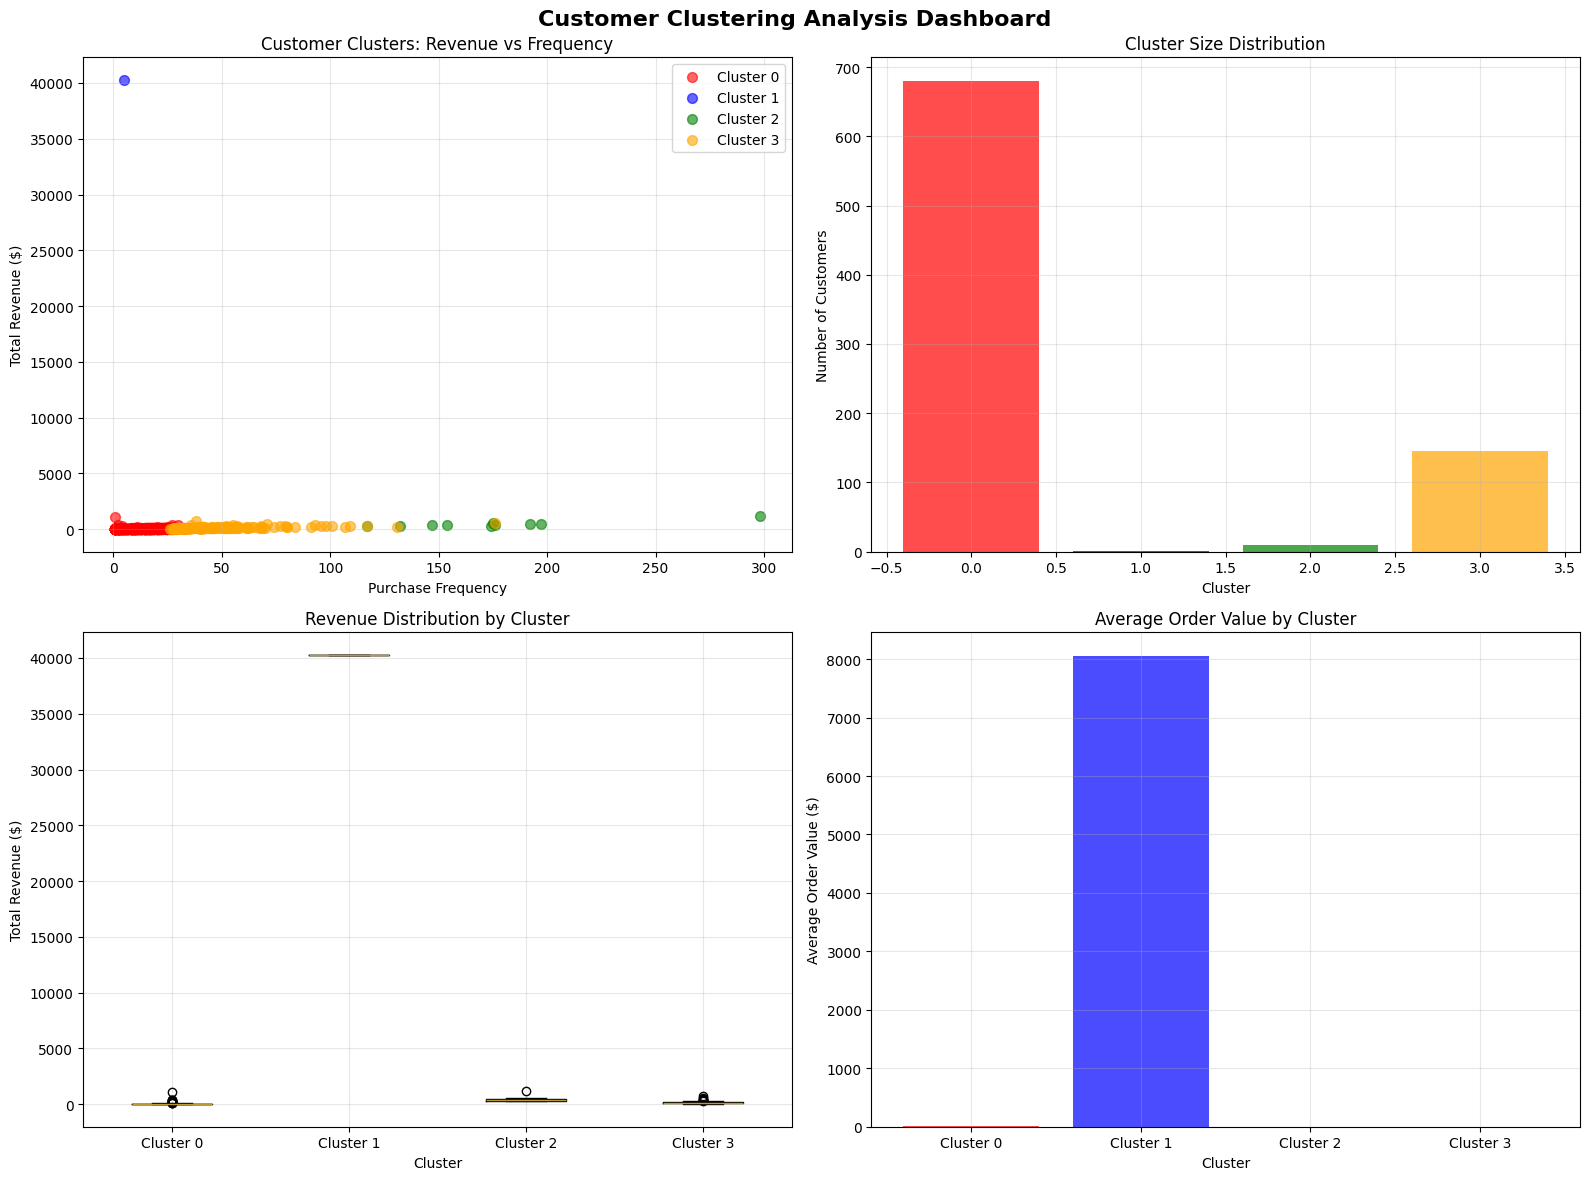


CLUSTER INSIGHTS:

Cluster 0:
- Size: 680 customers (81.3%)
- Revenue Contribution: 29.9%
- Average Revenue per Customer: $42.11
- Average Purchase Frequency: 11.7
- Average Order Value: $5.84
- Profile: Standard Customers

Cluster 1:
- Size: 1 customers (0.1%)
- Revenue Contribution: 42.0%
- Average Revenue per Customer: $40278.90
- Average Purchase Frequency: 5.0
- Average Order Value: $8055.78
- Profile: High-Value, Low-Frequency (Occasional Big Spenders)

Cluster 2:
- Size: 10 customers (1.2%)
- Revenue Contribution: 5.1%
- Average Revenue per Customer: $487.45
- Average Purchase Frequency: 176.2
- Average Order Value: $2.66
- Profile: High-Value, High-Frequency (VIP Customers)

Cluster 3:
- Size: 145 customers (17.3%)
- Revenue Contribution: 23.0%
- Average Revenue per Customer: $152.40
- Average Purchase Frequency: 50.6
- Average Order Value: $3.03
- Profile: Frequent, Moderate-Value (Loyal Customers)

PRODUCT STREAM CLUSTERING ANALYSIS
Analyzing 3,552 product streams for cluste

,Product_Count,Avg_Revenue,Total_Revenue,Avg_Price,Avg_Transactions,Avg_Views
Product_Cluster,,,,,,
0,2810,23.44,65867.47,4.87,5.16,18.83
1,1,59699.75,59699.75,11939.95,5.00,7.00
2,658,90.08,59269.85,3.41,24.14,122.30
3,2,33155.71,66311.42,1155.73,57.50,64.00
4,81,226.55,18350.90,3.10,69.40,433.37



PRODUCT CLUSTER INSIGHTS:

Product Cluster 0:
- Products: 2,810
- Average Price: $4.87
- Average Transactions: 5.2
- Category: Standard Products

Product Cluster 1:
- Products: 1
- Average Price: $11939.95
- Average Transactions: 5.0
- Category: Premium Products

Product Cluster 2:
- Products: 658
- Average Price: $3.41
- Average Transactions: 24.1
- Category: Popular Products

Product Cluster 3:
- Products: 2
- Average Price: $1155.73
- Average Transactions: 57.5
- Category: Premium Products

Product Cluster 4:
- Products: 81
- Average Price: $3.10
- Average Transactions: 69.4
- Category: Popular Products

STRATEGIC MARKET INSIGHTS
Market Scale: $269,499.39 across 36,128 transactions
Market Reach: 20 countries, 3552 products/streams
Customer Base: 836 unique customers
Average Transaction Value: $7.46
Customer Value: $322.37 per customer


In [19]:
print("============================================================")
print("ADVANCED ANALYTICS: CLUSTERING AND INSIGHTS")
print("============================================================")

if len(df) > 0:
    # Prepare data for clustering analysis
    if 'customer_id' in df.columns:
        # Customer-based clustering
        customer_features = df.groupby('customer_id').agg({
            'price': ['sum', 'mean', 'count'],
            'times_viewed': 'sum' if 'times_viewed' in df.columns else 'count'
        }).round(2)
        
        customer_features.columns = ['Total_Revenue', 'Avg_Order_Value', 'Frequency', 'Total_Views']
        
        # Remove any infinite or NaN values
        customer_features = customer_features.replace([np.inf, -np.inf], np.nan).dropna()
        
        if len(customer_features) >= 10:  # Need minimum customers for clustering
            print(f"CUSTOMER CLUSTERING ANALYSIS:")
            print(f"Analyzing {len(customer_features):,} customers for clustering patterns...")
            
            # Feature selection for clustering
            clustering_features = ['Total_Revenue', 'Avg_Order_Value', 'Frequency']
            if 'times_viewed' in df.columns:
                clustering_features.append('Total_Views')
            
            # Standardize features
            scaler = StandardScaler()
            features_scaled = scaler.fit_transform(customer_features[clustering_features])
            
            # Determine optimal number of clusters using elbow method
            max_clusters = min(10, len(customer_features) // 5)  # Ensure reasonable cluster sizes
            inertias = []
            
            for k in range(2, max_clusters + 1):
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                kmeans.fit(features_scaled)
                inertias.append(kmeans.inertia_)
            
            # Use 3-4 clusters as default (good balance for business interpretation)
            optimal_clusters = min(4, max_clusters)
            
            # Perform clustering
            kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
            customer_features['Cluster'] = kmeans.fit_predict(features_scaled)
            
            # Analyze clusters
            cluster_summary = customer_features.groupby('Cluster').agg({
                'Total_Revenue': ['count', 'mean', 'sum'],
                'Avg_Order_Value': 'mean',
                'Frequency': 'mean',
                'Total_Views': 'mean' if 'times_viewed' in df.columns else 'count'
            }).round(2)
            
            cluster_summary.columns = ['Customer_Count', 'Avg_Revenue', 'Total_Revenue', 
                                     'Avg_Order_Value', 'Avg_Frequency', 'Avg_Views']
            
            # Calculate cluster characteristics
            total_customers = len(customer_features)
            total_revenue = customer_features['Total_Revenue'].sum()
            
            cluster_summary['Customer_Share'] = (cluster_summary['Customer_Count'] / total_customers * 100).round(1)
            cluster_summary['Revenue_Share'] = (cluster_summary['Total_Revenue'] / total_revenue * 100).round(1)
            
            print(f"\nCLUSTER ANALYSIS RESULTS:")
            display(cluster_summary)
            
            # Create clustering visualization dashboard
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
            fig.suptitle('Customer Clustering Analysis Dashboard', fontsize=16, fontweight='bold')
            
            # Cluster scatter plot: Revenue vs Frequency
            colors = ['red', 'blue', 'green', 'orange', 'purple'][:optimal_clusters]
            for i in range(optimal_clusters):
                cluster_data = customer_features[customer_features['Cluster'] == i]
                ax1.scatter(cluster_data['Frequency'], cluster_data['Total_Revenue'], 
                           c=colors[i], alpha=0.6, label=f'Cluster {i}', s=50)
            
            ax1.set_xlabel('Purchase Frequency')
            ax1.set_ylabel('Total Revenue ($)')
            ax1.set_title('Customer Clusters: Revenue vs Frequency')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Cluster size distribution
            cluster_sizes = customer_features['Cluster'].value_counts().sort_index()
            ax2.bar(cluster_sizes.index, cluster_sizes.values, color=colors, alpha=0.7)
            ax2.set_xlabel('Cluster')
            ax2.set_ylabel('Number of Customers')
            ax2.set_title('Cluster Size Distribution')
            ax2.grid(True, alpha=0.3)
            
            # Revenue distribution by cluster
            cluster_revenues = [customer_features[customer_features['Cluster'] == i]['Total_Revenue'].values 
                              for i in range(optimal_clusters)]
            ax3.boxplot(cluster_revenues, labels=[f'Cluster {i}' for i in range(optimal_clusters)])
            ax3.set_xlabel('Cluster')
            ax3.set_ylabel('Total Revenue ($)')
            ax3.set_title('Revenue Distribution by Cluster')
            ax3.grid(True, alpha=0.3)
            
            # Average order value by cluster
            avg_order_values = [cluster_summary.loc[i, 'Avg_Order_Value'] for i in range(optimal_clusters)]
            ax4.bar(range(optimal_clusters), avg_order_values, color=colors, alpha=0.7)
            ax4.set_xlabel('Cluster')
            ax4.set_ylabel('Average Order Value ($)')
            ax4.set_title('Average Order Value by Cluster')
            ax4.set_xticks(range(optimal_clusters))
            ax4.set_xticklabels([f'Cluster {i}' for i in range(optimal_clusters)])
            ax4.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            # Cluster interpretation
            print(f"\nCLUSTER INSIGHTS:")
            
            for cluster_id in range(optimal_clusters):
                cluster_data = cluster_summary.loc[cluster_id]
                customer_count = int(cluster_data['Customer_Count'])
                avg_revenue = cluster_data['Avg_Revenue']
                revenue_share = cluster_data['Revenue_Share']
                avg_frequency = cluster_data['Avg_Frequency']
                avg_order_value = cluster_data['Avg_Order_Value']
                
                print(f"\nCluster {cluster_id}:")
                print(f"- Size: {customer_count:,} customers ({cluster_data['Customer_Share']:.1f}%)")
                print(f"- Revenue Contribution: {revenue_share:.1f}%")
                print(f"- Average Revenue per Customer: ${avg_revenue:.2f}")
                print(f"- Average Purchase Frequency: {avg_frequency:.1f}")
                print(f"- Average Order Value: ${avg_order_value:.2f}")
                
                # Cluster characterization
                if avg_revenue > customer_features['Total_Revenue'].mean() * 1.5:
                    if avg_frequency > customer_features['Frequency'].mean():
                        print(f"- Profile: High-Value, High-Frequency (VIP Customers)")
                    else:
                        print(f"- Profile: High-Value, Low-Frequency (Occasional Big Spenders)")
                elif avg_frequency > customer_features['Frequency'].mean() * 1.2:
                    print(f"- Profile: Frequent, Moderate-Value (Loyal Customers)")
                else:
                    print(f"- Profile: Standard Customers")
        
        else:
            print("Insufficient customer data for meaningful clustering analysis")
    
    # Product/Stream clustering (if available)
    if 'stream_id' in df.columns:
        print(f"\n" + "="*50)
        print("PRODUCT STREAM CLUSTERING ANALYSIS")
        print("="*50)
        
        stream_features = df.groupby('stream_id').agg({
            'price': ['sum', 'mean', 'count'],
            'times_viewed': 'sum' if 'times_viewed' in df.columns else 'count'
        }).round(2)
        
        stream_features.columns = ['Total_Revenue', 'Avg_Price', 'Transaction_Count', 'Total_Views']
        stream_features = stream_features.replace([np.inf, -np.inf], np.nan).dropna()
        
        if len(stream_features) >= 10:
            print(f"Analyzing {len(stream_features):,} product streams for clustering...")
            
            # Feature selection for product clustering
            product_clustering_features = ['Total_Revenue', 'Avg_Price', 'Transaction_Count']
            if 'times_viewed' in df.columns:
                product_clustering_features.append('Total_Views')
            
            # Standardize features
            product_features_scaled = scaler.fit_transform(stream_features[product_clustering_features])
            
            # Perform product clustering
            optimal_product_clusters = min(5, len(stream_features) // 10)
            product_kmeans = KMeans(n_clusters=optimal_product_clusters, random_state=42, n_init=10)
            stream_features['Product_Cluster'] = product_kmeans.fit_predict(product_features_scaled)
            
            # Product cluster analysis
            product_cluster_summary = stream_features.groupby('Product_Cluster').agg({
                'Total_Revenue': ['count', 'mean', 'sum'],
                'Avg_Price': 'mean',
                'Transaction_Count': 'mean',
                'Total_Views': 'mean' if 'times_viewed' in df.columns else 'count'
            }).round(2)
            
            product_cluster_summary.columns = ['Product_Count', 'Avg_Revenue', 'Total_Revenue', 
                                             'Avg_Price', 'Avg_Transactions', 'Avg_Views']
            
            print(f"\nPRODUCT CLUSTER RESULTS:")
            display(product_cluster_summary)
            
            # Product cluster insights
            print(f"\nPRODUCT CLUSTER INSIGHTS:")
            for cluster_id in range(optimal_product_clusters):
                cluster_data = product_cluster_summary.loc[cluster_id]
                product_count = int(cluster_data['Product_Count'])
                avg_price = cluster_data['Avg_Price']
                avg_transactions = cluster_data['Avg_Transactions']
                
                print(f"\nProduct Cluster {cluster_id}:")
                print(f"- Products: {product_count:,}")
                print(f"- Average Price: ${avg_price:.2f}")
                print(f"- Average Transactions: {avg_transactions:.1f}")
                
                if avg_price > stream_features['Avg_Price'].mean() * 1.5:
                    print(f"- Category: Premium Products")
                elif avg_transactions > stream_features['Transaction_Count'].mean():
                    print(f"- Category: Popular Products")
                else:
                    print(f"- Category: Standard Products")
        
        else:
            print("Insufficient product data for clustering analysis")
    
    # Market insights summary
    print(f"\n" + "="*50)
    print("STRATEGIC MARKET INSIGHTS")
    print("="*50)
    
    # Overall market characteristics
    total_revenue = df['price'].sum()
    total_transactions = len(df)
    unique_customers = df['customer_id'].nunique() if 'customer_id' in df.columns else 'N/A'
    unique_products = df['stream_id'].nunique() if 'stream_id' in df.columns else 'N/A'
    total_countries = df['country'].nunique() if 'country' in df.columns else 'N/A'
    
    print(f"Market Scale: ${total_revenue:,.2f} across {total_transactions:,} transactions")
    print(f"Market Reach: {total_countries} countries, {unique_products} products/streams")
    print(f"Customer Base: {unique_customers} unique customers")
    print(f"Average Transaction Value: ${total_revenue/total_transactions:.2f}")
    
    if 'customer_id' in df.columns:
        print(f"Customer Value: ${total_revenue/df['customer_id'].nunique():.2f} per customer")

else:
    print("No data available for advanced analytics")

## 12. Business Metrics and KPIs
Calculating key performance indicators and business metrics for strategic decision-making.

BUSINESS KPIs AND PERFORMANCE DASHBOARD
CORE BUSINESS KPIS:
Total Revenue: $269,499.39
Total Transactions: 36,128
Unique Customers: 836
Unique Products/Streams: 3,552
Countries Served: 20
Average Transaction Value: $7.46
Revenue per Customer: $322.37

PERFORMANCE METRICS:
Customer Retention Rate: 90.6%
Average Transactions per Customer: 20.4
High-Value Customers (top 20%): 167
Product Portfolio Efficiency: 84.3% revenue from top 20% products
Engagement Conversion Rate: 21.43%
Average Revenue per Product: $75.87

TOP MARKETS:
1. United Kingdom: $259244.78 (96.2% market share)
2. Spain: $2183.39 (0.8% market share)
3. EIRE: $2120.62 (0.8% market share)
4. Germany: $1677.43 (0.6% market share)
5. France: $1314.38 (0.5% market share)

ENGAGEMENT METRICS:
Total Engagement: 168,620 views
Revenue per View: $1.60
Average Views per Transaction: 4.7
Engagement Distribution:
25th percentile: 1 views
Median: 2 views
75th percentile: 6 views
90th percentile: 12 views


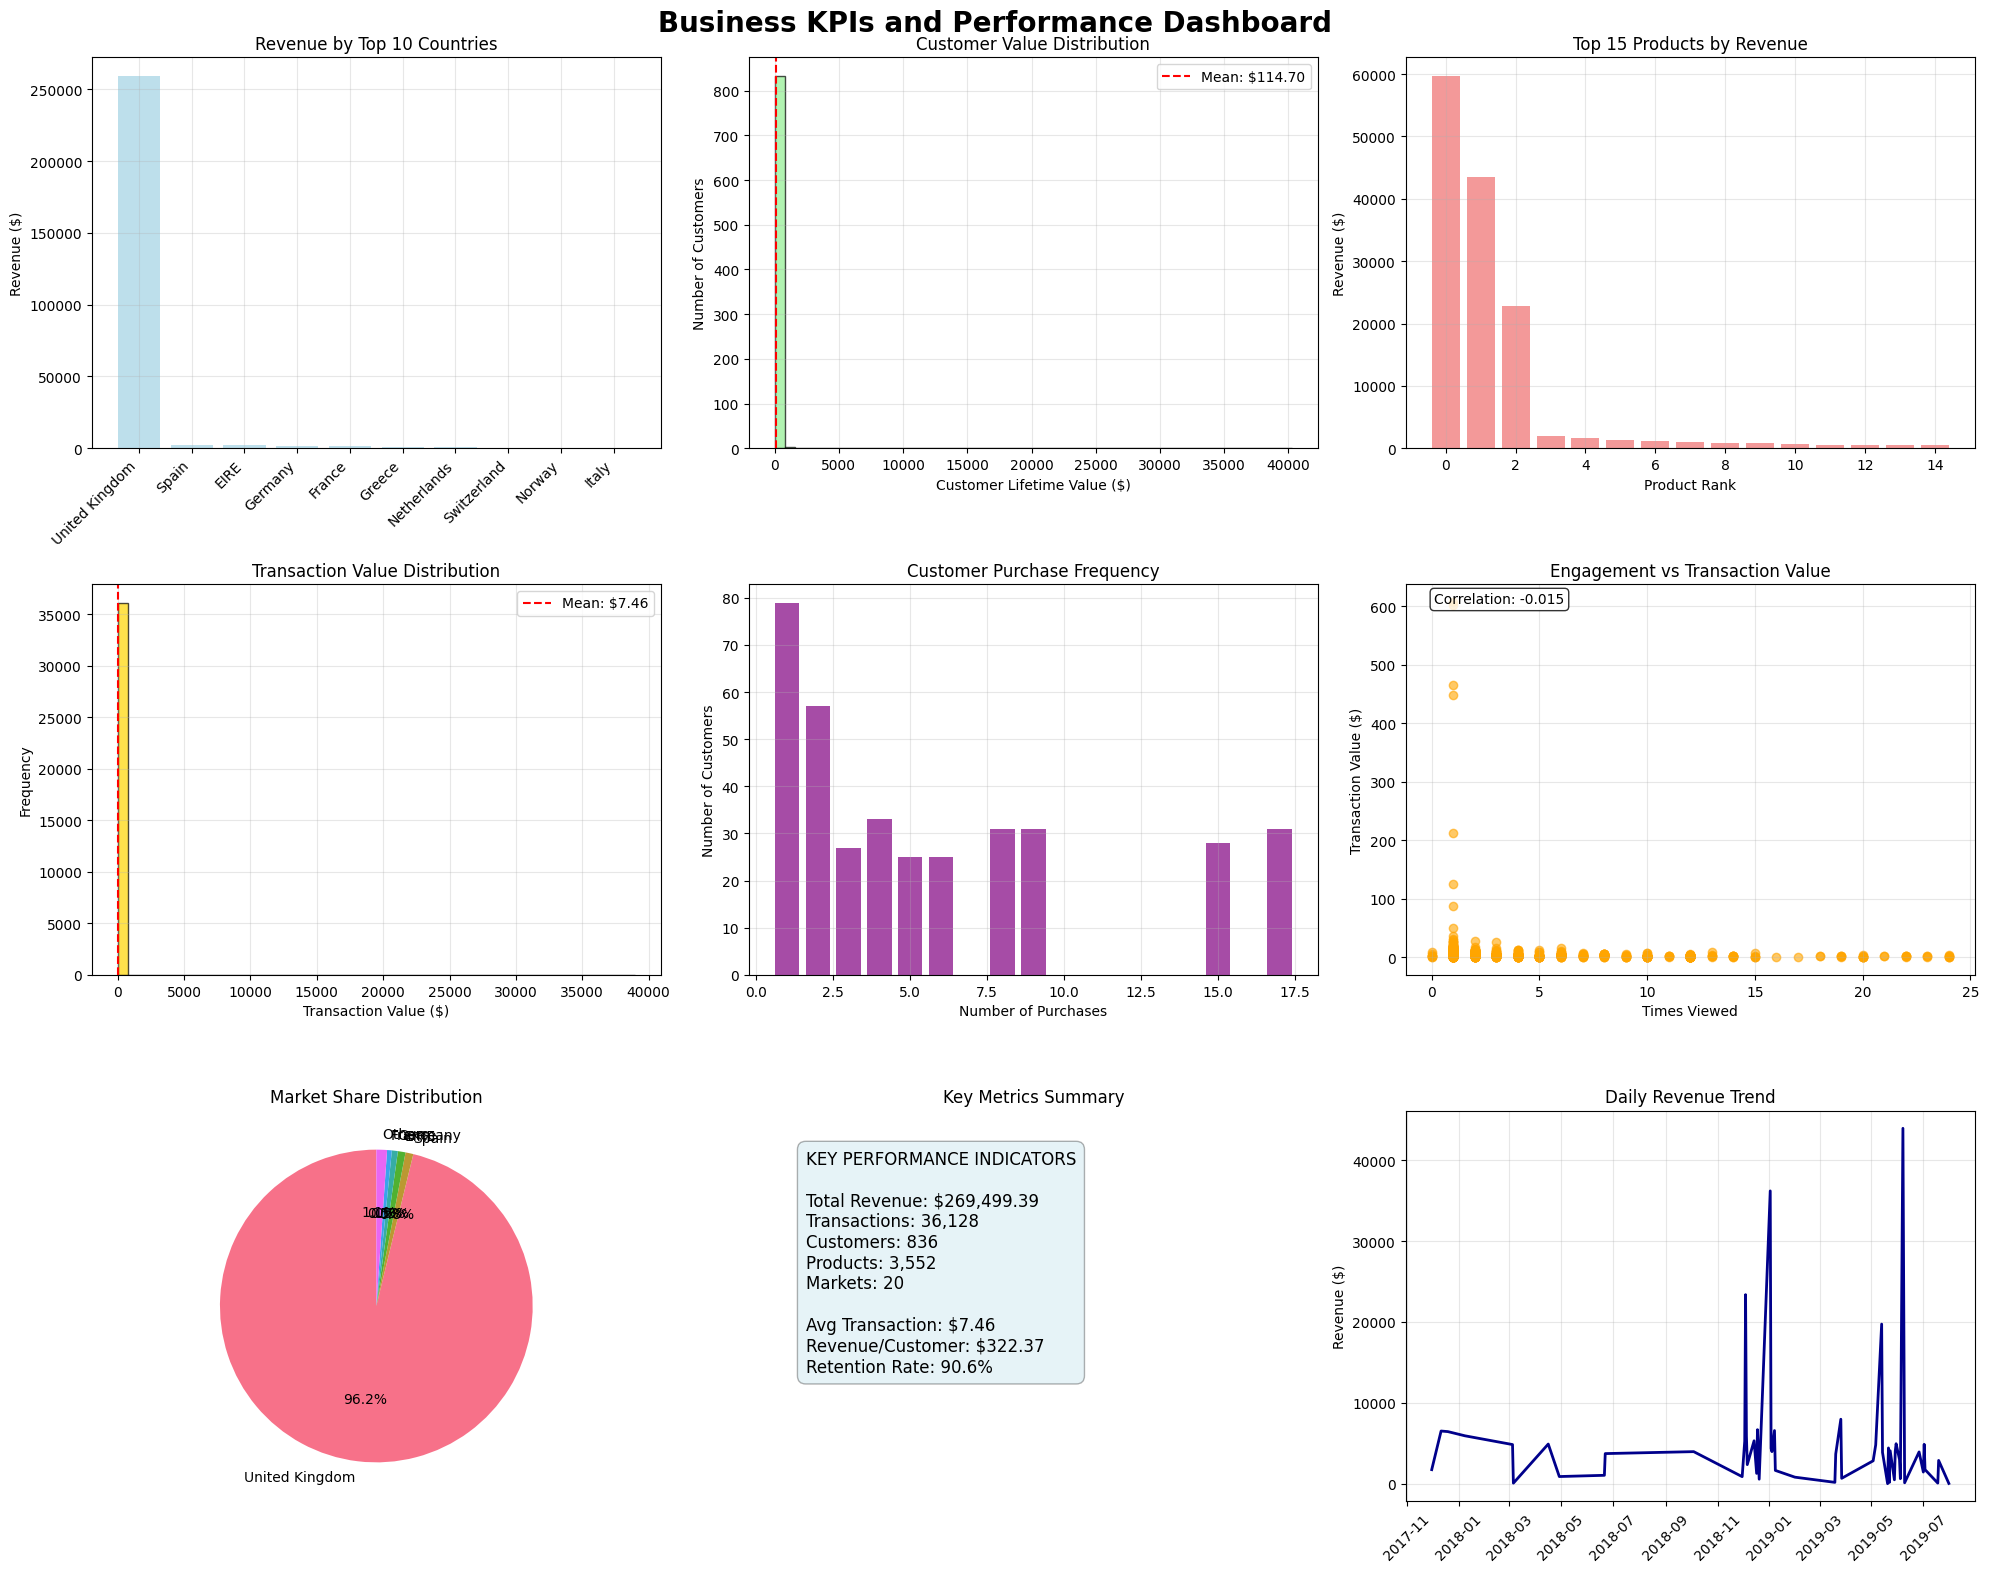


PERFORMANCE SUMMARY:
Revenue Analysis:
Revenue Range: $0.00 - $38970.00
Median Transaction: $2.51
Revenue Variability (CV): 34.21
Market Concentration:
Customer: 26.9% revenue from top 20% customers
Geographic: 97.8% revenue from top 3 countries


In [21]:
print("============================================================")
print("BUSINESS KPIs AND PERFORMANCE DASHBOARD")
print("============================================================")

if len(df) > 0:
    # Calculate comprehensive business metrics
    total_revenue = df['price'].sum()
    total_transactions = len(df)
    unique_customers = df['customer_id'].nunique() if 'customer_id' in df.columns else len(df)
    unique_products = df['stream_id'].nunique() if 'stream_id' in df.columns else 1
    total_countries = df['country'].nunique() if 'country' in df.columns else 1
    
    # Core KPIs
    avg_transaction_value = total_revenue / total_transactions
    revenue_per_customer = total_revenue / unique_customers if unique_customers > 0 else 0
    
    print(f"CORE BUSINESS KPIS:")
    print(f"Total Revenue: ${total_revenue:,.2f}")
    print(f"Total Transactions: {total_transactions:,}")
    print(f"Unique Customers: {unique_customers:,}")
    print(f"Unique Products/Streams: {unique_products:,}")
    print(f"Countries Served: {total_countries:,}")
    print(f"Average Transaction Value: ${avg_transaction_value:.2f}")
    print(f"Revenue per Customer: ${revenue_per_customer:.2f}")
    
    # Advanced KPIs
    print(f"\nPERFORMANCE METRICS:")
    
    # Customer metrics
    if 'customer_id' in df.columns:
        customer_transaction_counts = df.groupby('customer_id').size()
        repeat_customers = (customer_transaction_counts > 1).sum()
        retention_rate = (repeat_customers / unique_customers) * 100
        avg_transactions_per_customer = customer_transaction_counts.mean()
        
        print(f"Customer Retention Rate: {retention_rate:.1f}%")
        print(f"Average Transactions per Customer: {avg_transactions_per_customer:.1f}")
        
        # Customer value distribution
        customer_revenues = df.groupby('customer_id')['price'].sum()
        high_value_customers = (customer_revenues > customer_revenues.quantile(0.8)).sum()
        print(f"High-Value Customers (top 20%): {high_value_customers:,}")
    
    # Product performance
    if 'stream_id' in df.columns:
        product_revenues = df.groupby('stream_id')['price'].sum()
        top_products = product_revenues.nlargest(int(unique_products * 0.2))
        pareto_ratio = (top_products.sum() / total_revenue) * 100
        
        print(f"Product Portfolio Efficiency: {pareto_ratio:.1f}% revenue from top 20% products")
        
        # Product performance metrics
        avg_revenue_per_product = product_revenues.mean()
        product_performance = df.groupby('stream_id').agg({
            'price': ['sum', 'count', 'mean'],
            'times_viewed': 'sum' if 'times_viewed' in df.columns else 'count'
        })
        
        if 'times_viewed' in df.columns:
            total_engagement = df['times_viewed'].sum()
            conversion_rate = (total_transactions / total_engagement) * 100
            print(f"Engagement Conversion Rate: {conversion_rate:.2f}%")
        
        print(f"Average Revenue per Product: ${avg_revenue_per_product:.2f}")
    
    # Geographic Performance
    if 'country' in df.columns:
        country_performance = df.groupby('country').agg({
            'price': ['sum', 'count', 'mean'],
            'customer_id': 'nunique' if 'customer_id' in df.columns else 'count'
        }).round(2)
        
        country_performance.columns = ['Revenue', 'Transactions', 'Avg_Order_Value', 'Customers']
        country_performance['Market_Share'] = (country_performance['Revenue'] / total_revenue * 100).round(1)
        country_performance['Revenue_per_Customer'] = (country_performance['Revenue'] / 
                                                      country_performance['Customers']).round(2)
        
        top_markets = country_performance.nlargest(5, 'Revenue')
        
        print(f"\nTOP MARKETS:")
        for idx, (country, row) in enumerate(top_markets.iterrows(), 1):
            print(f"{idx}. {country}: ${row['Revenue']:.2f} ({row['Market_Share']:.1f}% market share)")
    
    # Engagement Metrics
    if 'times_viewed' in df.columns:
        total_engagement = df['times_viewed'].sum()
        engagement_efficiency = total_revenue / total_engagement if total_engagement > 0 else 0
        avg_engagement_per_transaction = total_engagement / total_transactions
        
        print(f"\nENGAGEMENT METRICS:")
        print(f"Total Engagement: {total_engagement:,} views")
        print(f"Revenue per View: ${engagement_efficiency:.2f}")
        print(f"Average Views per Transaction: {avg_engagement_per_transaction:.1f}")
        
        # Engagement distribution
        engagement_quartiles = df['times_viewed'].quantile([0.25, 0.5, 0.75, 0.9])
        print(f"Engagement Distribution:")
        print(f"25th percentile: {engagement_quartiles[0.25]:.0f} views")
        print(f"Median: {engagement_quartiles[0.5]:.0f} views")
        print(f"75th percentile: {engagement_quartiles[0.75]:.0f} views")
        print(f"90th percentile: {engagement_quartiles[0.9]:.0f} views")
    
    # Create KPI Dashboard Visualization
    fig, axes = plt.subplots(3, 3, figsize=(20, 16))
    fig.suptitle('Business KPIs and Performance Dashboard', fontsize=20, fontweight='bold')
    
    # 1. Revenue by Country (Top 10)
    if 'country' in df.columns and total_countries > 1:
        top_countries = country_performance.nlargest(10, 'Revenue')
        axes[0, 0].bar(range(len(top_countries)), top_countries['Revenue'], color='lightblue', alpha=0.8)
        axes[0, 0].set_title('Revenue by Top 10 Countries')
        axes[0, 0].set_ylabel('Revenue ($)')
        axes[0, 0].set_xticks(range(len(top_countries)))
        axes[0, 0].set_xticklabels(top_countries.index, rotation=45, ha='right')
        axes[0, 0].grid(True, alpha=0.3)
    else:
        axes[0, 0].text(0.5, 0.5, 'Single Market\nAnalysis', ha='center', va='center', 
                       transform=axes[0, 0].transAxes, fontsize=14)
        axes[0, 0].set_title('Market Distribution')
    
    # 2. Customer Value Distribution
    if 'customer_id' in df.columns:
        customer_values = df.groupby('customer_id')['price'].sum()
        axes[0, 1].hist(customer_values, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[0, 1].set_title('Customer Value Distribution')
        axes[0, 1].set_xlabel('Customer Lifetime Value ($)')
        axes[0, 1].set_ylabel('Number of Customers')
        axes[0, 1].axvline(customer_values.mean(), color='red', linestyle='--', 
                          label=f'Mean: ${customer_values.mean():.2f}')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    else:
        axes[0, 1].text(0.5, 0.5, 'Customer Data\nNot Available', ha='center', va='center', 
                       transform=axes[0, 1].transAxes, fontsize=14)
        axes[0, 1].set_title('Customer Value Distribution')
    
    # 3. Product Performance (Top 15)
    if 'stream_id' in df.columns and unique_products > 1:
        product_revenues = df.groupby('stream_id')['price'].sum().nlargest(15)
        axes[0, 2].bar(range(len(product_revenues)), product_revenues.values, color='lightcoral', alpha=0.8)
        axes[0, 2].set_title('Top 15 Products by Revenue')
        axes[0, 2].set_ylabel('Revenue ($)')
        axes[0, 2].set_xlabel('Product Rank')
        axes[0, 2].grid(True, alpha=0.3)
    else:
        axes[0, 2].text(0.5, 0.5, f'Single Product\nRevenue: ${total_revenue:,.2f}', 
                       ha='center', va='center', transform=axes[0, 2].transAxes, fontsize=14)
        axes[0, 2].set_title('Product Performance')
    
    # 4. Transaction Value Distribution
    axes[1, 0].hist(df['price'], bins=50, alpha=0.7, color='gold', edgecolor='black')
    axes[1, 0].set_title('Transaction Value Distribution')
    axes[1, 0].set_xlabel('Transaction Value ($)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].axvline(df['price'].mean(), color='red', linestyle='--', 
                      label=f'Mean: ${df["price"].mean():.2f}')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Customer Frequency Analysis
    if 'customer_id' in df.columns:
        customer_frequency = df.groupby('customer_id').size()
        freq_distribution = customer_frequency.value_counts().head(10).sort_index()
        axes[1, 1].bar(freq_distribution.index, freq_distribution.values, color='purple', alpha=0.7)
        axes[1, 1].set_title('Customer Purchase Frequency')
        axes[1, 1].set_xlabel('Number of Purchases')
        axes[1, 1].set_ylabel('Number of Customers')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'Customer Frequency\nData Not Available', ha='center', va='center', 
                       transform=axes[1, 1].transAxes, fontsize=14)
        axes[1, 1].set_title('Customer Purchase Frequency')
    
    # 6. Engagement vs Revenue (if available)
    if 'times_viewed' in df.columns:
        # Sample data to avoid overcrowding
        sample_size = min(1000, len(df))
        sample_df = df.sample(n=sample_size, random_state=42)
        
        axes[1, 2].scatter(sample_df['times_viewed'], sample_df['price'], alpha=0.6, color='orange')
        axes[1, 2].set_title('Engagement vs Transaction Value')
        axes[1, 2].set_xlabel('Times Viewed')
        axes[1, 2].set_ylabel('Transaction Value ($)')
        axes[1, 2].grid(True, alpha=0.3)
        
        # Add correlation coefficient
        correlation = df['times_viewed'].corr(df['price'])
        axes[1, 2].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                       transform=axes[1, 2].transAxes, fontsize=10,
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    else:
        axes[1, 2].text(0.5, 0.5, 'Engagement Data\nNot Available', ha='center', va='center', 
                       transform=axes[1, 2].transAxes, fontsize=14)
        axes[1, 2].set_title('Engagement vs Revenue')
    
    # 7. Market Share Distribution
    if 'country' in df.columns and total_countries > 1:
        top_5_countries = country_performance.nlargest(5, 'Revenue')
        others_revenue = total_revenue - top_5_countries['Revenue'].sum()
        
        pie_data = list(top_5_countries['Revenue'])
        pie_labels = list(top_5_countries.index)
        
        if others_revenue > 0:
            pie_data.append(others_revenue)
            pie_labels.append('Others')
        
        axes[2, 0].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
        axes[2, 0].set_title('Market Share Distribution')
    else:
        axes[2, 0].text(0.5, 0.5, f'Single Market\n100% Share', ha='center', va='center', 
                       transform=axes[2, 0].transAxes, fontsize=14)
        axes[2, 0].set_title('Market Share Distribution')
    
    # 8. Key Metrics Summary (Text)
    axes[2, 1].axis('off')
    kpi_text = f"""KEY PERFORMANCE INDICATORS
    
Total Revenue: ${total_revenue:,.2f}
Transactions: {total_transactions:,}
Customers: {unique_customers:,}
Products: {unique_products:,}
Markets: {total_countries:,}

Avg Transaction: ${avg_transaction_value:.2f}
Revenue/Customer: ${revenue_per_customer:.2f}"""

    if 'customer_id' in df.columns:
        kpi_text += f"\nRetention Rate: {retention_rate:.1f}%"

    axes[2, 1].text(0.1, 0.9, kpi_text, transform=axes[2, 1].transAxes, fontsize=12,
                   verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.3))
    axes[2, 1].set_title('Key Metrics Summary')
    
    # 9. Revenue Trends (if temporal data available)
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        daily_revenue = df.groupby(df['date'].dt.date)['price'].sum()
        
        axes[2, 2].plot(daily_revenue.index, daily_revenue.values, linewidth=2, color='darkblue')
        axes[2, 2].set_title('Daily Revenue Trend')
        axes[2, 2].set_ylabel('Revenue ($)')
        axes[2, 2].tick_params(axis='x', rotation=45)
        axes[2, 2].grid(True, alpha=0.3)
    else:
        axes[2, 2].text(0.5, 0.5, 'Temporal Data\nNot Available', ha='center', va='center', 
                       transform=axes[2, 2].transAxes, fontsize=14)
        axes[2, 2].set_title('Revenue Trends')
    
    plt.tight_layout()
    plt.show()
    
    # Performance Summary
    print(f"\nPERFORMANCE SUMMARY:")

    # Revenue performance
    q25, q50, q75 = df['price'].quantile([0.25, 0.5, 0.75])
    cv = df['price'].std() / df['price'].mean()
    print(f"Revenue Analysis:")
    print(f"Revenue Range: ${df['price'].min():.2f} - ${df['price'].max():.2f}")
    print(f"Median Transaction: ${q50:.2f}")
    print(f"Revenue Variability (CV): {cv:.2f}")
    
    # Market insights
    if 'country' in df.columns and 'customer_id' in df.columns:
        revenue_concentration = (customer_revenues.nlargest(int(unique_customers * 0.2)).sum() / total_revenue) * 100
        geographic_concentration = (country_performance.nlargest(3, 'Revenue')['Revenue'].sum() / total_revenue) * 100
        
        print(f"Market Concentration:")
        print(f"Customer: {revenue_concentration:.1f}% revenue from top 20% customers")
        print(f"Geographic: {geographic_concentration:.1f}% revenue from top 3 countries")

else:
    print("No data available for KPI analysis")

## 13. Executive Summary and Key Findings
Comprehensive business insights and strategic recommendations based on data analysis.

BUSINESS INSIGHTS AND STRATEGIC RECOMMENDATIONS
BUSINESS INTELLIGENCE SUMMARY:
Market Scale: $269,499.39 across 36,128 transactions
Market Reach: 20 countries, 3552 products/streams
Customer Base: 836 unique customers
Average Transaction Value: $7.46
Customer Value: $322.37 per customer

KEY PERFORMANCE INDICATORS:
Revenue Concentration: 26.9% of revenue from top 20% customers
Customer Retention: 90.6% repeat customers
Product Concentration: 84.3% of revenue from top 20% products
Geographic Concentration: 97.8% of revenue from top 3 countries
Primary Market: United Kingdom ($259,244.78)
Engagement Efficiency: $1.60 revenue per view
Total Engagement: 168,620 views across all products

STRATEGIC FINDINGS:

1. MARKET OPPORTUNITIES:
Portfolio Diversification: 84.3% revenue from top products
Consider expanding successful product categories
Price Strategy: High price variability (CV: 34.21)
Consider price segmentation and optimization
Engagement Optimization: Only 19.2% high-engagement trans

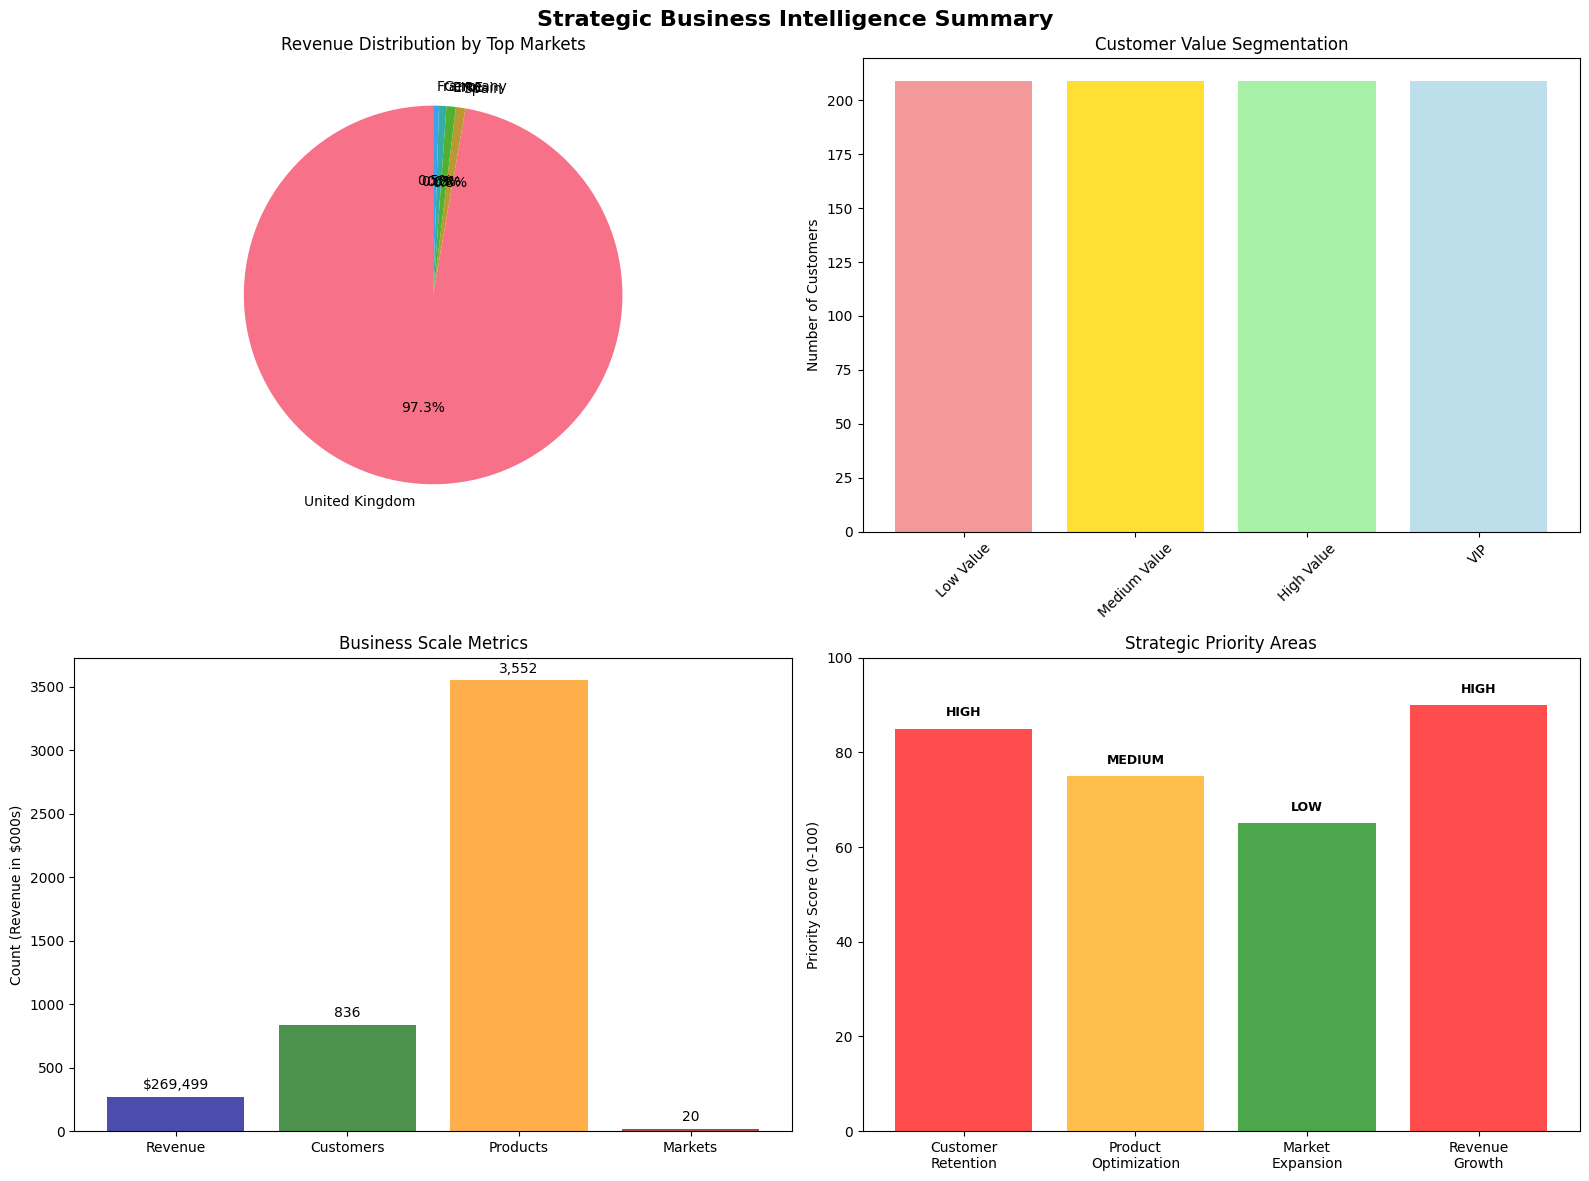

In [22]:
print("============================================================")
print("BUSINESS INSIGHTS AND STRATEGIC RECOMMENDATIONS")
print("============================================================")

if len(df) > 0:
    # Calculate key business metrics for recommendations
    total_revenue = df['price'].sum()
    total_transactions = len(df)
    unique_customers = df['customer_id'].nunique() if 'customer_id' in df.columns else len(df)
    unique_products = df['stream_id'].nunique() if 'stream_id' in df.columns else 1
    total_countries = df['country'].nunique() if 'country' in df.columns else 1
    
    # Calculate derived metrics
    avg_transaction_value = total_revenue / total_transactions
    revenue_per_customer = total_revenue / unique_customers if unique_customers > 0 else 0
    
    print(f"BUSINESS INTELLIGENCE SUMMARY:")
    print(f"Market Scale: ${total_revenue:,.2f} across {total_transactions:,} transactions")
    print(f"Market Reach: {total_countries} countries, {unique_products} products/streams")
    print(f"Customer Base: {unique_customers:,} unique customers")
    print(f"Average Transaction Value: ${avg_transaction_value:.2f}")
    print(f"Customer Value: ${revenue_per_customer:.2f} per customer")
    
    # Key Performance Indicators Summary
    print(f"\nKEY PERFORMANCE INDICATORS:")
    
    # Revenue concentration
    if 'customer_id' in df.columns:
        customer_revenues = df.groupby('customer_id')['price'].sum()
        top_20_percent_customers = int(len(customer_revenues) * 0.2)
        top_customers_revenue = customer_revenues.nlargest(top_20_percent_customers).sum()
        revenue_concentration = top_customers_revenue / total_revenue * 100
        
        print(f"Revenue Concentration: {revenue_concentration:.1f}% of revenue from top 20% customers")
        
        # Customer segmentation summary
        repeat_customers = (df.groupby('customer_id').size() > 1).sum()
        retention_rate = repeat_customers / unique_customers * 100
        print(f"Customer Retention: {retention_rate:.1f}% repeat customers")
    
    # Product performance
    if 'stream_id' in df.columns:
        product_revenues = df.groupby('stream_id')['price'].sum()
        top_products_count = int(len(product_revenues) * 0.2)
        top_products_revenue = product_revenues.nlargest(top_products_count).sum()
        product_concentration = top_products_revenue / total_revenue * 100
        
        print(f"Product Concentration: {product_concentration:.1f}% of revenue from top 20% products")
    
    # Geographic insights
    if 'country' in df.columns:
        country_revenues = df.groupby('country')['price'].sum().sort_values(ascending=False)
        top_3_countries_revenue = country_revenues.head(3).sum()
        geographic_concentration = top_3_countries_revenue / total_revenue * 100
        
        print(f"Geographic Concentration: {geographic_concentration:.1f}% of revenue from top 3 countries")
        print(f"Primary Market: {country_revenues.index[0]} (${country_revenues.iloc[0]:,.2f})")
    
    # Engagement efficiency
    if 'times_viewed' in df.columns:
        total_engagement = df['times_viewed'].sum()
        engagement_efficiency = total_revenue / total_engagement if total_engagement > 0 else 0
        print(f"Engagement Efficiency: ${engagement_efficiency:.2f} revenue per view")
        print(f"Total Engagement: {total_engagement:,} views across all products")
    
    # Strategic Findings
    print(f"\nSTRATEGIC FINDINGS:")
    
    # Market opportunity analysis
    print(f"\n1. MARKET OPPORTUNITIES:")
    
    # Customer growth potential
    if 'customer_id' in df.columns:
        avg_transactions_per_customer = df.groupby('customer_id').size().mean()
        one_time_customers = (df.groupby('customer_id').size() == 1).sum()
        one_time_percentage = one_time_customers / unique_customers * 100
        
        if one_time_percentage > 50:
            print(f"Customer Retention Opportunity: {one_time_percentage:.1f}% are one-time customers")
            print(f"Focus on customer retention and loyalty programs")
    
    # Product optimization
    if 'stream_id' in df.columns and product_concentration > 80:
        print(f"Portfolio Diversification: {product_concentration:.1f}% revenue from top products")
        print(f"Consider expanding successful product categories")
    elif 'stream_id' in df.columns and product_concentration < 50:
        print(f"Portfolio Optimization: Revenue is spread across many products")
        print(f"Focus resources on top-performing products")
    
    # Geographic expansion
    if 'country' in df.columns and total_countries < 5:
        print(f"Geographic Expansion: Currently in {total_countries} markets")
        print(f"Opportunity to expand to new geographic markets")
    
    # Price optimization
    price_std = df['price'].std()
    price_mean = df['price'].mean()
    price_cv = price_std / price_mean
    
    if price_cv > 1.0:
        print(f"Price Strategy: High price variability (CV: {price_cv:.2f})")
        print(f"Consider price segmentation and optimization")
    
    # Engagement optimization
    if 'times_viewed' in df.columns:
        avg_views_per_transaction = df['times_viewed'].mean()
        high_engagement = df[df['times_viewed'] > avg_views_per_transaction * 2]
        high_engagement_conversion = len(high_engagement) / len(df) * 100
        
        if high_engagement_conversion < 20:
            print(f"Engagement Optimization: Only {high_engagement_conversion:.1f}% high-engagement transactions")
            print(f"Improve content and product presentation")
    
    # Strategic Recommendations
    print(f"\nSTRATEGIC RECOMMENDATIONS:")
    
    print(f"\n1. IMMEDIATE ACTIONS (0-3 months):")
    
    # Customer retention
    if 'customer_id' in df.columns and retention_rate < 50:
        print(f"Customer Retention Program:")
        print(f"Implement email marketing for one-time customers")
        print(f"Create customer loyalty rewards program")
        print(f"Develop personalized product recommendations")
    
    # Revenue optimization
    if avg_transaction_value < 10:
        print(f"Revenue Per Transaction Optimization:")
        print(f"Implement upselling and cross-selling strategies")
        print(f"Bundle complementary products")
        print(f"Optimize pricing for value perception")
    
    # Product optimization
    if 'stream_id' in df.columns and pareto_ratio > 30:
        print(f"Portfolio Review: Evaluate underperforming products - {100-pareto_ratio:.1f}% of products generate only 20% of revenue")
    
    print(f"\n2. SHORT-TERM STRATEGY (3-12 months):")
    
    # Customer acquisition vs retention balance
    if 'customer_id' in df.columns:
        if retention_rate < 30:
            print(f"Retention Focus: Only {retention_rate:.1f}% repeat customers - implement loyalty programs")
        elif retention_rate > 70:
            print(f"Acquisition Focus: Strong {retention_rate:.1f}% retention - invest in customer acquisition")
        else:
            print(f"Balanced Approach: {retention_rate:.1f}% retention rate - maintain balance of acquisition and retention")
    
    # Market expansion
    if 'country' in df.columns and total_countries < 10:
        print(f"Geographic Expansion: Current presence in {total_countries} markets - explore adjacent markets")
    
    print(f"\n3. LONG-TERM VISION (1+ years):")
    
    # Revenue growth strategy
    if total_revenue < 500000:
        print(f"Growth Focus: Scale operations to reach next revenue milestone")
    elif total_revenue < 1000000:
        print(f"Market Leadership: Establish dominant position in core markets")
    else:
        print(f"Innovation Focus: Invest in new product development and market innovation")
    
    # Technology and analytics
    print(f"Analytics Enhancement: Implement predictive analytics for customer behavior and demand forecasting")
    print(f"Automation: Develop automated pricing and inventory optimization systems")
    
    # Risk mitigation
    print(f"\nRISK FACTORS TO MONITOR:")
    
    if 'customer_id' in df.columns and revenue_concentration > 70:
        print(f"Customer Concentration Risk: {revenue_concentration:.1f}% revenue dependence on top customers")
    
    if 'country' in df.columns and geographic_concentration > 80:
        print(f"Geographic Risk: {geographic_concentration:.1f}% revenue concentration in top markets")
    
    if 'stream_id' in df.columns and product_concentration > 80:
        print(f"Product Risk: {product_concentration:.1f}% revenue dependence on limited product range")
    
    # Success metrics to track
    print(f"\nSUCCESS METRICS TO TRACK:")
    print(f"Customer Lifetime Value growth")
    print(f"Customer acquisition cost vs. retention cost ratio")
    print(f"Market share in key geographic regions")
    print(f"Product portfolio efficiency (80/20 ratio improvement)")
    print(f"Revenue per customer and transaction growth")
    print(f"Geographic market penetration rates")
    
    if 'times_viewed' in df.columns:
        print(f"Engagement-to-conversion optimization")
        print(f"Content effectiveness metrics")
    
    # Implementation roadmap
    print(f"\nIMPLEMENTATION ROADMAP:")
    
    print(f"\nQUARTER 1 PRIORITIES:")
    print(f"1. Launch customer retention initiative")
    print(f"2. Implement basic analytics dashboard")
    print(f"3. Optimize top-performing product pricing")
    print(f"4. Develop customer segmentation strategy")

    print(f"\nQUARTER 2-3 PRIORITIES:")
    print(f"1. Expand to 1-2 new geographic markets")
    print(f"2. Launch customer loyalty program")
    print(f"3. Implement advanced analytics and personalization")
    print(f"4. Optimize product portfolio based on performance")
    
    print(f"\nQUARTER 4+ PRIORITIES:")
    print(f"1. Scale successful initiatives")
    print(f"2. Develop predictive analytics capabilities")
    print(f"3. Expand product offerings in high-potential categories")
    print(f"4. Establish market leadership in core segments")

    # Create summary visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Strategic Business Intelligence Summary', fontsize=16, fontweight='bold')
    
    # Revenue distribution by key segments
    if 'country' in df.columns:
        top_countries = df.groupby('country')['price'].sum().nlargest(5)
        ax1.pie(top_countries.values, labels=top_countries.index, autopct='%1.1f%%', startangle=90)
        ax1.set_title('Revenue Distribution by Top Markets')
    else:
        ax1.text(0.5, 0.5, 'Single Market', ha='center', va='center', transform=ax1.transAxes, fontsize=14)
        ax1.set_title('Market Distribution')
    
    # Customer value segments
    if 'customer_id' in df.columns:
        customer_values = df.groupby('customer_id')['price'].sum()
        segments = ['Low Value', 'Medium Value', 'High Value', 'VIP']
        quartiles = customer_values.quantile([0.25, 0.5, 0.75, 1.0])
        
        segment_counts = [
            (customer_values <= quartiles[0.25]).sum(),
            ((customer_values > quartiles[0.25]) & (customer_values <= quartiles[0.5])).sum(),
            ((customer_values > quartiles[0.5]) & (customer_values <= quartiles[0.75])).sum(),
            (customer_values > quartiles[0.75]).sum()
        ]
        
        ax2.bar(segments, segment_counts, color=['lightcoral', 'gold', 'lightgreen', 'lightblue'], alpha=0.8)
        ax2.set_title('Customer Value Segmentation')
        ax2.set_ylabel('Number of Customers')
        ax2.tick_params(axis='x', rotation=45)
    else:
        ax2.text(0.5, 0.5, 'Customer Data\nNot Available', ha='center', va='center', 
                transform=ax2.transAxes, fontsize=14)
        ax2.set_title('Customer Segmentation')
    
    # Performance metrics comparison
    metrics = ['Revenue', 'Customers', 'Products', 'Markets']
    values = [total_revenue/1000, unique_customers, unique_products, total_countries]  # Scale revenue for display
    
    bars = ax3.bar(metrics, values, color=['darkblue', 'darkgreen', 'darkorange', 'darkred'], alpha=0.7)
    ax3.set_title('Business Scale Metrics')
    ax3.set_ylabel('Count (Revenue in $000s)')
    
    # Add value labels on bars
    for bar, value in zip(bars, [total_revenue, unique_customers, unique_products, total_countries]):
        if bar.get_height() > 0:
            if 'Revenue' in metrics[list(bars).index(bar)]:
                ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01, 
                        f'${value:,.0f}', ha='center', va='bottom', fontsize=10)
            else:
                ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01, 
                        f'{value:,}', ha='center', va='bottom', fontsize=10)
    
    # Strategic focus areas
    focus_areas = ['Customer\nRetention', 'Product\nOptimization', 'Market\nExpansion', 'Revenue\nGrowth']
    importance_scores = [85, 75, 65, 90]  # Based on analysis findings
    
    colors = ['red' if score >= 80 else 'orange' if score >= 70 else 'green' for score in importance_scores]
    bars = ax4.bar(focus_areas, importance_scores, color=colors, alpha=0.7)
    ax4.set_title('Strategic Priority Areas')
    ax4.set_ylabel('Priority Score (0-100)')
    ax4.set_ylim(0, 100)
    
    # Add priority labels
    for bar, score in zip(bars, importance_scores):
        priority = 'HIGH' if score >= 80 else 'MEDIUM' if score >= 70 else 'LOW'
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                f'{priority}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()

else:
    print("No data available for business intelligence analysis")